# Mount Drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')
%cd 'drive/My Drive/Self Case Study-1'
!ls

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/My Drive/Self Case Study-1
BestModel.sav	 EDA_and_FE.ipynb   result
Blog.gdoc	 Final.ipynb	    SavedModel
data		 ML_Models.ipynb    talk2mubasir0587@gmail.com_CS1.docx
DL_Models.ipynb  preprocessing.sav  talk2mubasir0587@gmail.com_CS1.pdf


# Import Libraries

In [2]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
from scipy.stats import uniform, randint
import matplotlib.pyplot as plt
import seaborn as sns
from prettytable import PrettyTable
import os
from IPython.display import Image
import joblib

from sklearn.metrics import  roc_curve, auc, roc_auc_score
from sklearn.model_selection import train_test_split, RandomizedSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler, normalize
from sklearn.linear_model import LogisticRegression, LassoCV , LassoLarsCV, RidgeCV
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.calibration import CalibratedClassifierCV
from sklearn.feature_selection import mutual_info_classif, SelectKBest, RFE

from xgboost import XGBClassifier

from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE

from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs

# Import Dataset

In [3]:
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')
submission = pd.read_csv('data/sample_submission.csv')
print(train.shape)
print(test.shape)
print(submission.shape)

print('-'*100)

X = train.drop(['id','target'], axis=1)
y = train['target']
test = test.drop(['id'], axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.04, stratify=y, random_state=42) 
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)
print(test.shape)

(250, 302)
(19750, 301)
(19750, 2)
----------------------------------------------------------------------------------------------------
(240, 300) (240,)
(10, 300) (10,)
(19750, 300)


# Train Test Data

In [ ]:
X = train.drop(['id','target'], axis=1)
y = train['target']
test = test.drop(['id'], axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.04, stratify=y, random_state=42) 
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)
print(test.shape)

(240, 300) (240,)
(10, 300) (10,)
(19750, 300)


# Scaling data

In [ ]:
def scale(X_train, X_test, test):
    '''
    Normalize the input varaible

    X_train: train variable
    X_test: test variable
    test: Submission test Variable

    Return:
    Scaled/Normalized values of each varaibles
    '''
    scaler  = StandardScaler()
    X_train  = scaler.fit_transform(X_train)
    test = scaler.transform(test)
    X_test = scaler.transform(X_test)
    return X_train, X_test, test

# ROC curve Plot

In [ ]:
# https://medium.com/analytics-vidhya/kaggle-competition-dont-overfit-ii-74cf2d9deed5
def plot_roc(train_true, train_pred, test_true, test_pred, axis, model_name, cv_score, train_acc, test_acc, n_classes=2):
    '''
    Compute ROC curve and ROC area for each class
    
    Parameters:
    train_true: train true label
    train_pred: train predict probabilities value
    test_true: Sample Test true label
    test_pred: Sample Test predict probabilities value
    axis: axis of plot
    model_name: Name of Model curve
    cv_score: CV score of model
    train_acc: Train accuracy of Model
    test_acc: Test accuracy of Model
    n_classes: number of unique classes
    
    Return:
    Nothing   
    '''
    # For train
    tr_fpr = dict()
    tr_tpr = dict()
    tr_roc_auc = dict()
    for i in range(n_classes):
        tr_fpr[i], tr_tpr[i], _ = roc_curve(train_true, train_pred[:, i])
        tr_roc_auc[i] = auc(tr_fpr[i], tr_tpr[i])

    # For Sample Test
    te_fpr = dict()
    te_tpr = dict()
    te_roc_auc = dict()
    for i in range(n_classes):
        te_fpr[i], te_tpr[i], _ = roc_curve(test_true, test_pred[:, i])
        te_roc_auc[i] = auc(te_fpr[i], te_tpr[i])

    # Plot roc for train
    axis.plot(tr_fpr[1], tr_tpr[1], color='red', alpha=0.5, 
            lw=2, label='ROC curve for Train (area = %0.2f)' % tr_roc_auc[1])
    # Plot roc for Sample Test
    axis.plot(te_fpr[1], te_tpr[1], color='green', alpha=0.5, 
            lw=2, label='ROC curve for Sample Test (area = %0.2f)' % te_roc_auc[1])
    axis.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    axis.set_xlim([0.0, 1.0])
    axis.set_ylim([0.0, 1.05])
    axis.set_xlabel('False Positive Rate')
    axis.set_ylabel('True Positive Rate')
    axis.set_title(model_name+' Receiver operating characteristic: train vs Sample Test')
    axis.legend(loc="lower right")

    axis.text(x=1.0, y=0.40, transform=axis.transAxes, s="Mean CV ROC_AUC: {:.4f}".format(cv_score),\
            fontweight='demibold', fontsize=10, verticalalignment='top', horizontalalignment='right',\
            backgroundcolor='white', color='r')
    axis.text(x=1.0, y=0.34, transform=axis.transAxes, s="Train Accuracy: {:.4f}".format(train_acc),\
            fontweight='demibold', fontsize=12, verticalalignment='top', horizontalalignment='right',\
            backgroundcolor='white', color='b')
    axis.text(x=1.0, y=0.28, transform=axis.transAxes, s="Sample Test Accuracy: {:.4f}".format(test_acc),\
            fontweight='demibold', fontsize=12, verticalalignment='top', horizontalalignment='right',\
            backgroundcolor='white', color='g')

# Classifiers Algorithm

In [ ]:
def Model():
    '''
    There are total 8 algorithm with list of their hyperparameters
    1. Logistic Regression (linear)
    2. Linear Discriminate Analysis(linear)
    3. K Neighbors Classifiers (non-linear)
    4. Decision Tree (non-linear)
    5. Naive Bayes (non-linear)
    6. Support Vector Classifiers (non-linear)
    7. Random Forest (non-linear)
    8. XGBoost (non-linear)

    Return:
    all the models along with their name, list of hyperparamaters and short_name
    '''
    # Hyperparameters for Logistic Regression
    LRparams = {
        "class_weight":["balanced"],
        "penalty" : ["l2","l1"],
        "tol" : [0.0001,0.0002,0.0003],
        "max_iter": [100,200,300],
        "C" :[0.001,0.01, 0.1, 1, 10, 100],
        "intercept_scaling": [1, 2, 3, 4],
        "solver":["liblinear"],
    }
    # Hyperparameters for Linear Discriminate Analysis
    LDAparams = {
        "solver" : ["svd"],
        "tol" : [0.0001,0.0002,0.0003]
    }
    # Hyperparameters for K Neighbors Classifiers
    KNNparams = {
        'n_neighbors':[5,6,7,8,9,10],
        'leaf_size':[1,2,3,5],
        'weights':['uniform', 'distance'],
        'algorithm':['auto', 'ball_tree','kd_tree','brute'],
        'n_jobs':[-1]
    }
    # Hyperparameters for Decision Tree
    DTparams = {
        "max_depth": [3, 5 , 10, None],
        "max_features": ["auto", "sqrt", "log2", None],
        "min_samples_leaf": [1,5,10,50],
        "criterion": ["gini", "entropy"],
        "class_weight":["balanced"]
    }
    # Hyperparameters for Naive Bayes
    NBparams = {
        'var_smoothing': np.logspace(0,-9, num=100)   
    }
    # Hyperparameters for Support Vector Classifiers
    SVCparams = {
        'kernel': ['rbf','linear'], 
        'gamma': [0.0001, 0.001, 0.01, 0.1, 1,'auto'],
        'C': [1, 6, 7, 8, 9, 10, 11, 12, 10, 50, 100, 200, 300],
        'class_weight': ['balanced'],
        'probability': [True]
    }
    # Hyperparameters for Random Forest
    RFparams = {
        'criterion':['gini','entropy'],
        'n_estimators':[10,15,20,25,30],
        'min_samples_leaf':[1,2,3,4,5],
        'min_samples_split':[3,4,5,6,7], 
        'n_jobs':[-1],
        'class_weight' : ["balanced", "balanced_subsample"]
    }
    # Hyperparameters for XGBoost
    XGBparams={
        'learning_rate':[0.01,0.03,0.05,0.1,0.15,0.2],
        'n_estimators':[10,20,30,40,100],
        'max_depth':[2,3,5,10],
        'colsample_bytree':[0.1,0.3,0.5,1],
        'subsample':[0.1,0.3,0.5,1],
        'n_jobs':[-1],
    }
    # Models
    models = []
    models.append(('Logistic Regression', LogisticRegression(random_state=42), LRparams,'LR'))
    models.append(('Linear Discriminate Analysis', LinearDiscriminantAnalysis(), LDAparams,'LDA'))
    models.append(('K Neighbors Classifiers', KNeighborsClassifier(), KNNparams,'KNN'))
    models.append(('Decision Tree', DecisionTreeClassifier(random_state=42), DTparams,'DT'))
    models.append(('Naive Bayes', GaussianNB(), NBparams,'NB'))
    models.append(('Support Vector Classifiers', SVC(random_state=42), SVCparams,'SVC'))
    models.append(('Random Forest', RandomForestClassifier(random_state=42), RFparams,'RF'))
    models.append(('XGBoost', XGBClassifier(random_state=42), XGBparams,'XGB'))
    return models

# Save Test Result

In [ ]:
def save_test_result(pred, Modeltype, Modelname):

    '''
    Make a dataframe of submission ids and respective predicted probability
    and save into localdisk

    pred: predictions of model
    Modeltype: type of model
    Modelname: Name of classifiers

    Return:
    Nothing
    '''
    if not os.path.isdir('result/'+Modeltype):
        os.mkdir('result/'+Modeltype)

    id = submission['id']
    test_df = pd.DataFrame(np.column_stack((id,pred)), columns=['id','target'])
    test_df['id'] = test_df['id'].astype('int32')
    test_df.to_csv('result/'+Modeltype+'/'+Modeltype+'_'+Modelname+'submit.csv', index=False)

# Save Model Into Drive

In [ ]:
def save_model(model, Modeltype, Modelname):
    '''
    It will save to trained model into drive for use in future
    model: classifiers
    Modeltype: type of model
    Modelname: name of classifiers

    Return:
    Nothing
    '''
    if not os.path.isdir('SavedModel/'+Modeltype):
        os.mkdir('SavedModel/'+Modeltype)
        
    filename = 'SavedModel/'+Modeltype+'/'+Modeltype+'_'+Modelname+'model.sav'
    joblib.dump(model, filename)

# Template for Best Model with best params

In [ ]:
def trainWithBestModelAndParams(X_train, X_test, y_train, y_test, Modeltype, Test = test, CV=5, Scaling=True):
    '''
    Select Best ML model with their best hyperparamaters
    
    Parameters:
    X_train: train data
    X_test: Sample test data
    y_train: train true label
    y_test: Sample Test true label
    Test: test data for submission
    CV: Number of cross-validation folds
    Scaling: For Scaling of Input varaibles 
    
    Return:
    Best Classifiers   
    '''
    models = Model()
    # Scaling Features
    if Scaling:
        X_train, X_test, Test = scale(X_train, X_test, Test)

    #RandomSearch    
    result = []
    print('{:31}| {:6} | {}'.format('Estimator', 'Score', 'Best Parameters'))
    print('-'*180)
    for name, model, params, abr in models:
        rs=RandomizedSearchCV(model ,param_distributions = params ,verbose=0, n_jobs=-1, scoring='roc_auc',cv = CV, n_iter=10, random_state=42)
        rs.fit(X_train,y_train)
        result.append((name, rs.best_score_, rs.best_params_, rs.best_estimator_, abr))
        print('{:31}| {:.4f} | {}'.format(name, rs.best_score_, rs.best_params_))

    # Selecting Best Score Model
    mx = -1
    best_model = 0
    for i in result:
        if(i[1]>mx):
            mx = i[1]
            best_model = i
    print('_'*180)
    print('{:15}:{}'.format('Best Model', best_model[0]))
    print('{:15}:{:.4}'.format('CV Score', best_model[1]))
    print('{:15}:{}'.format('Parameters', best_model[2]))
    print('{:15}:{}'.format('Estimator', best_model[3]))
    print('_'*180)
    
    #Training Models
    print('Training Models..')
    sns.set(rc={'figure.figsize':(30,30)})
    fig, ax = plt.subplots(4, 2,sharex='col', sharey='row')
    ax = ax.reshape(-1)

    classifiers = []
    for i, model in enumerate(result):
        clf = model[3]
        clf = CalibratedClassifierCV(clf, cv=10, method='sigmoid')
        clf.fit(X_train,y_train)

        #Save Model into disk
        save_model(clf, Modeltype, model[4])

        #Append classifier into list
        classifiers.append((model[0], clf))

        #Predicting
        pred = clf.predict_proba(Test)[:,1]

        #Saving prediction into disk
        save_test_result(pred, Modeltype, model[4])

        #Plotting ROC AUC
        plot_roc(y_train, clf.predict_proba(X_train), y_test, clf.predict_proba(X_test),\
                 ax[i], model[0], model[1], clf.score(X_train,y_train), clf.score(X_test, y_test), n_classes=2)

        print(model[0]+' done.')
    print('_'*180)
    print('Plotting ROC curve')
    plt.show()
    classifiers = dict(classifiers)
    return best_model, classifiers

# Baseline Model

## Model

Estimator                      | Score  | Best Parameters
------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Logistic Regression            | 0.7937 | {'tol': 0.0001, 'solver': 'liblinear', 'penalty': 'l1', 'max_iter': 300, 'intercept_scaling': 3, 'class_weight': 'balanced', 'C': 0.1}
Linear Discriminate Analysis   | 0.7165 | {'tol': 0.0001, 'solver': 'svd'}
K Neighbors Classifiers        | 0.6088 | {'weights': 'distance', 'n_neighbors': 9, 'n_jobs': -1, 'leaf_size': 5, 'algorithm': 'auto'}
Decision Tree                  | 0.6387 | {'min_samples_leaf': 50, 'max_features': None, 'max_depth': 5, 'criterion': 'gini', 'class_weight': 'balanced'}
Naive Bayes                    | 0.7586 | {'var_smoothing': 1.0}
Support Vector Classifiers     | 0.7621 | {'probability': True, 'kernel': 'rbf', 'gamma': 'auto', 'class_weight': 'balanced', 'C': 11}
Random Forest       

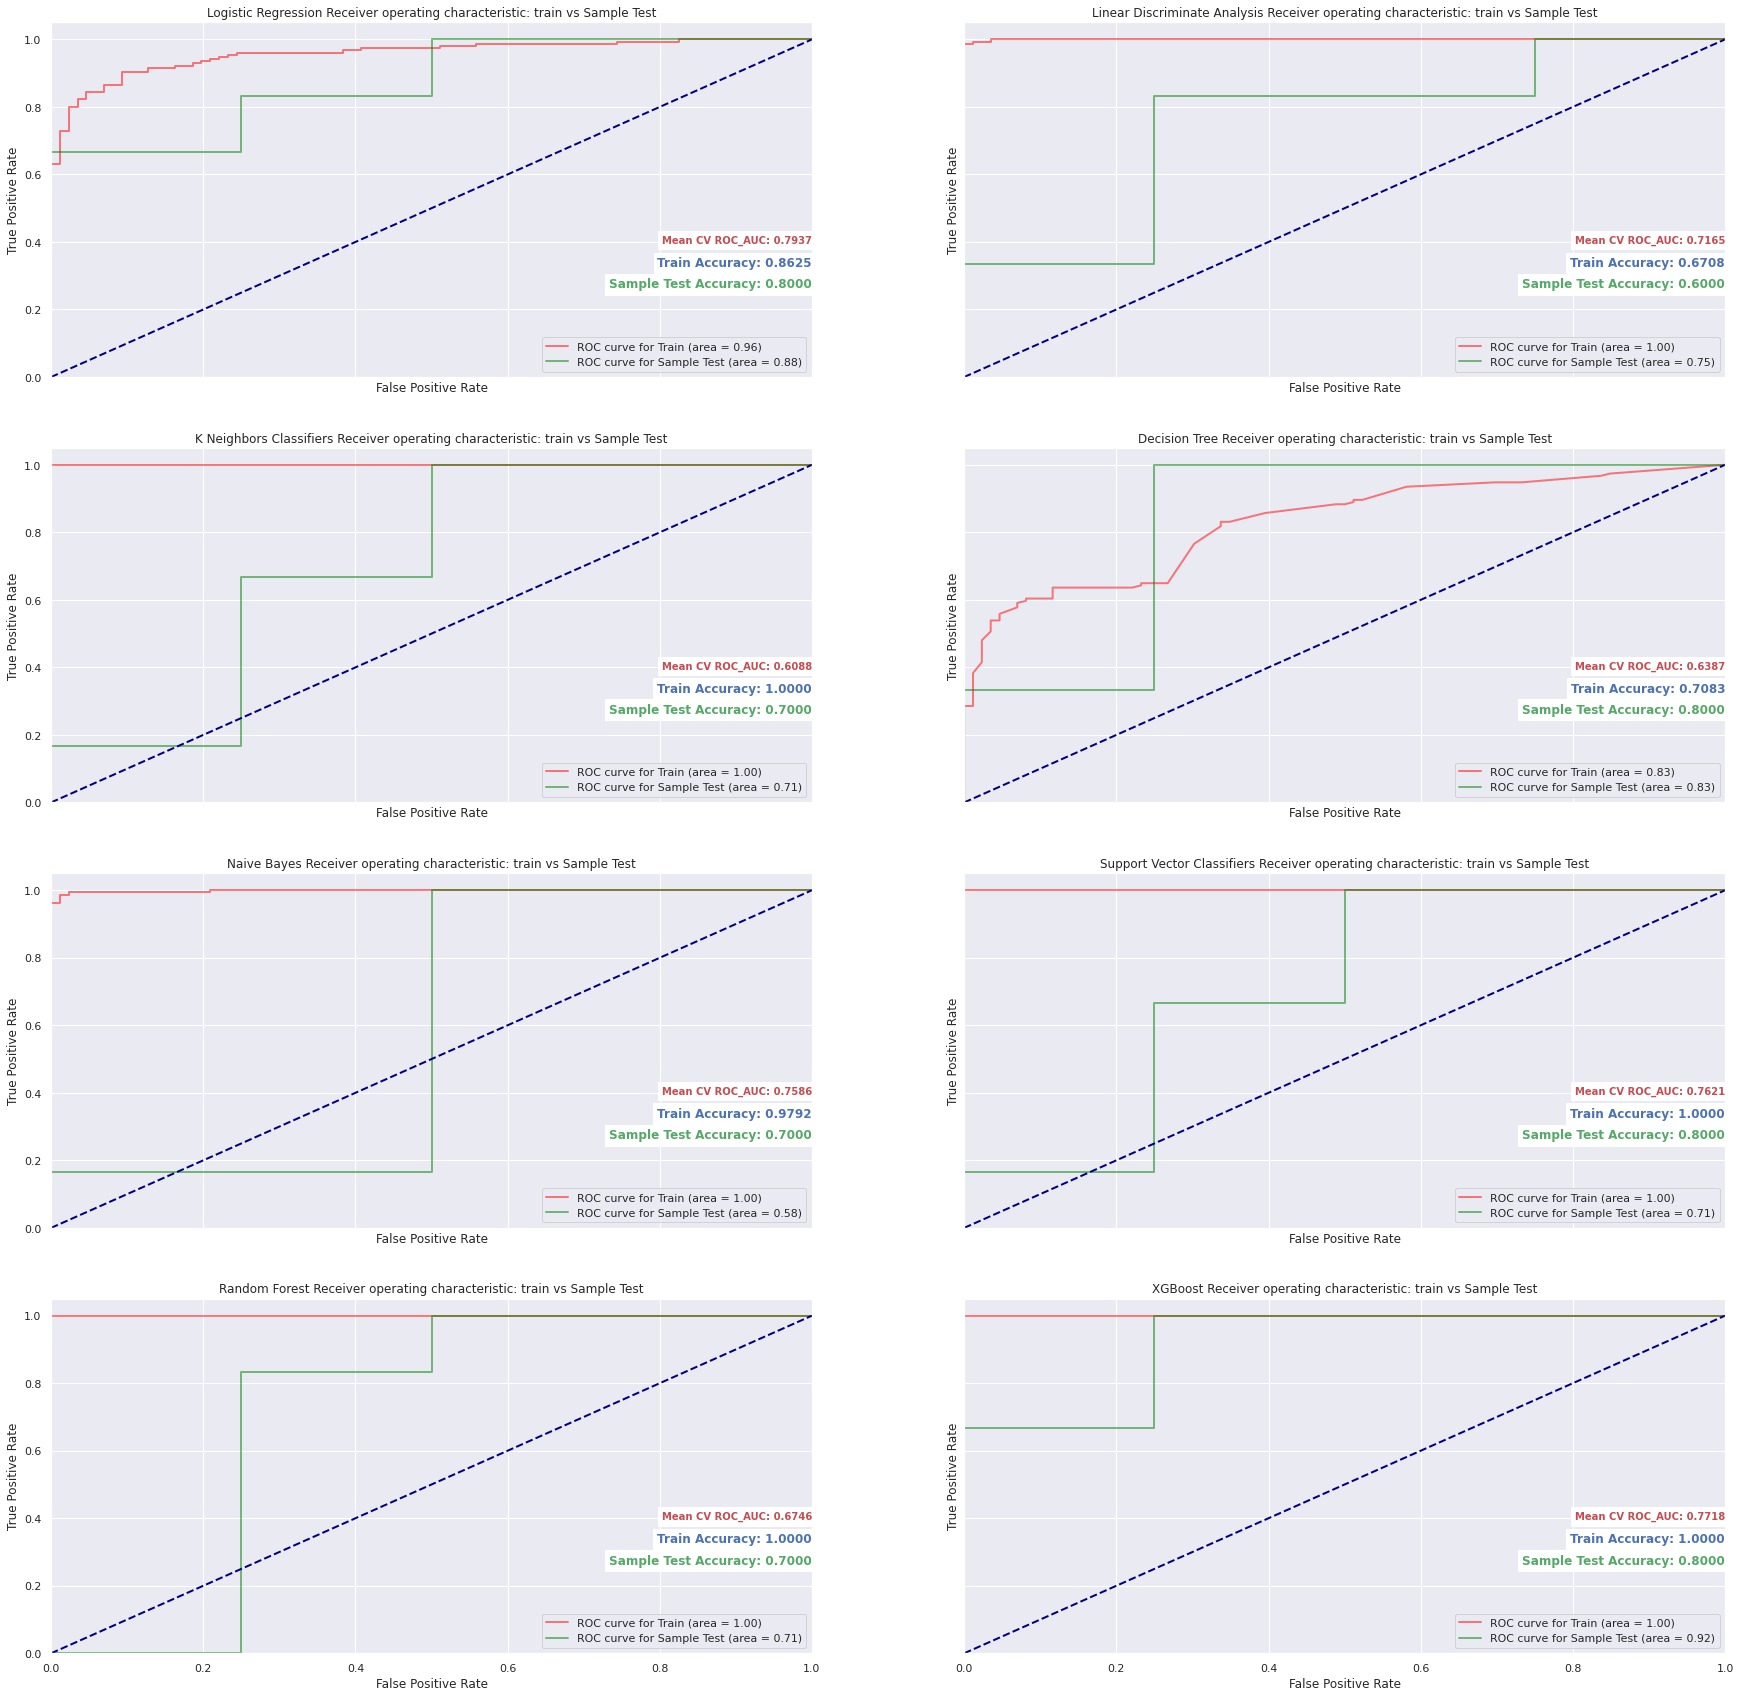

In [ ]:
baseline_best_model, BM_clfs = trainWithBestModelAndParams(X_train, X_test, y_train, y_test, 'Baseline', test, CV=5)

## Results

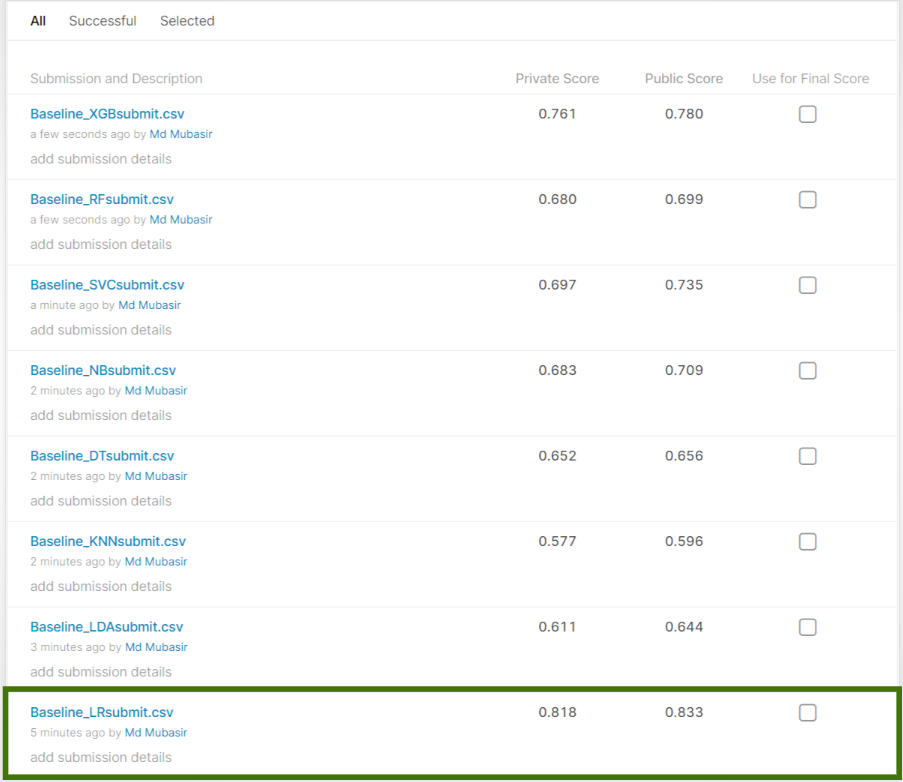

In [ ]:
Image('result/Baseline/Baseline_submissions.png')

# Random Sampling Model

## Over Sampling

### Model

In [ ]:
smote = SMOTE()
Xo_train, yo_train = smote.fit_sample(X_train, y_train)
print(Xo_train.shape, yo_train.shape) # (308, 300) (308,)

(308, 300) (308,)


Estimator                      | Score  | Best Parameters
------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Logistic Regression            | 0.9155 | {'tol': 0.0001, 'solver': 'liblinear', 'penalty': 'l2', 'max_iter': 100, 'intercept_scaling': 3, 'class_weight': 'balanced', 'C': 0.1}
Linear Discriminate Analysis   | 0.6952 | {'tol': 0.0001, 'solver': 'svd'}
K Neighbors Classifiers        | 0.5165 | {'weights': 'distance', 'n_neighbors': 9, 'n_jobs': -1, 'leaf_size': 5, 'algorithm': 'auto'}
Decision Tree                  | 0.7087 | {'min_samples_leaf': 50, 'max_features': None, 'max_depth': 5, 'criterion': 'gini', 'class_weight': 'balanced'}
Naive Bayes                    | 0.9086 | {'var_smoothing': 1.0}
Support Vector Classifiers     | 0.9267 | {'probability': True, 'kernel': 'rbf', 'gamma': 'auto', 'class_weight': 'balanced', 'C': 11}
Random Forest       

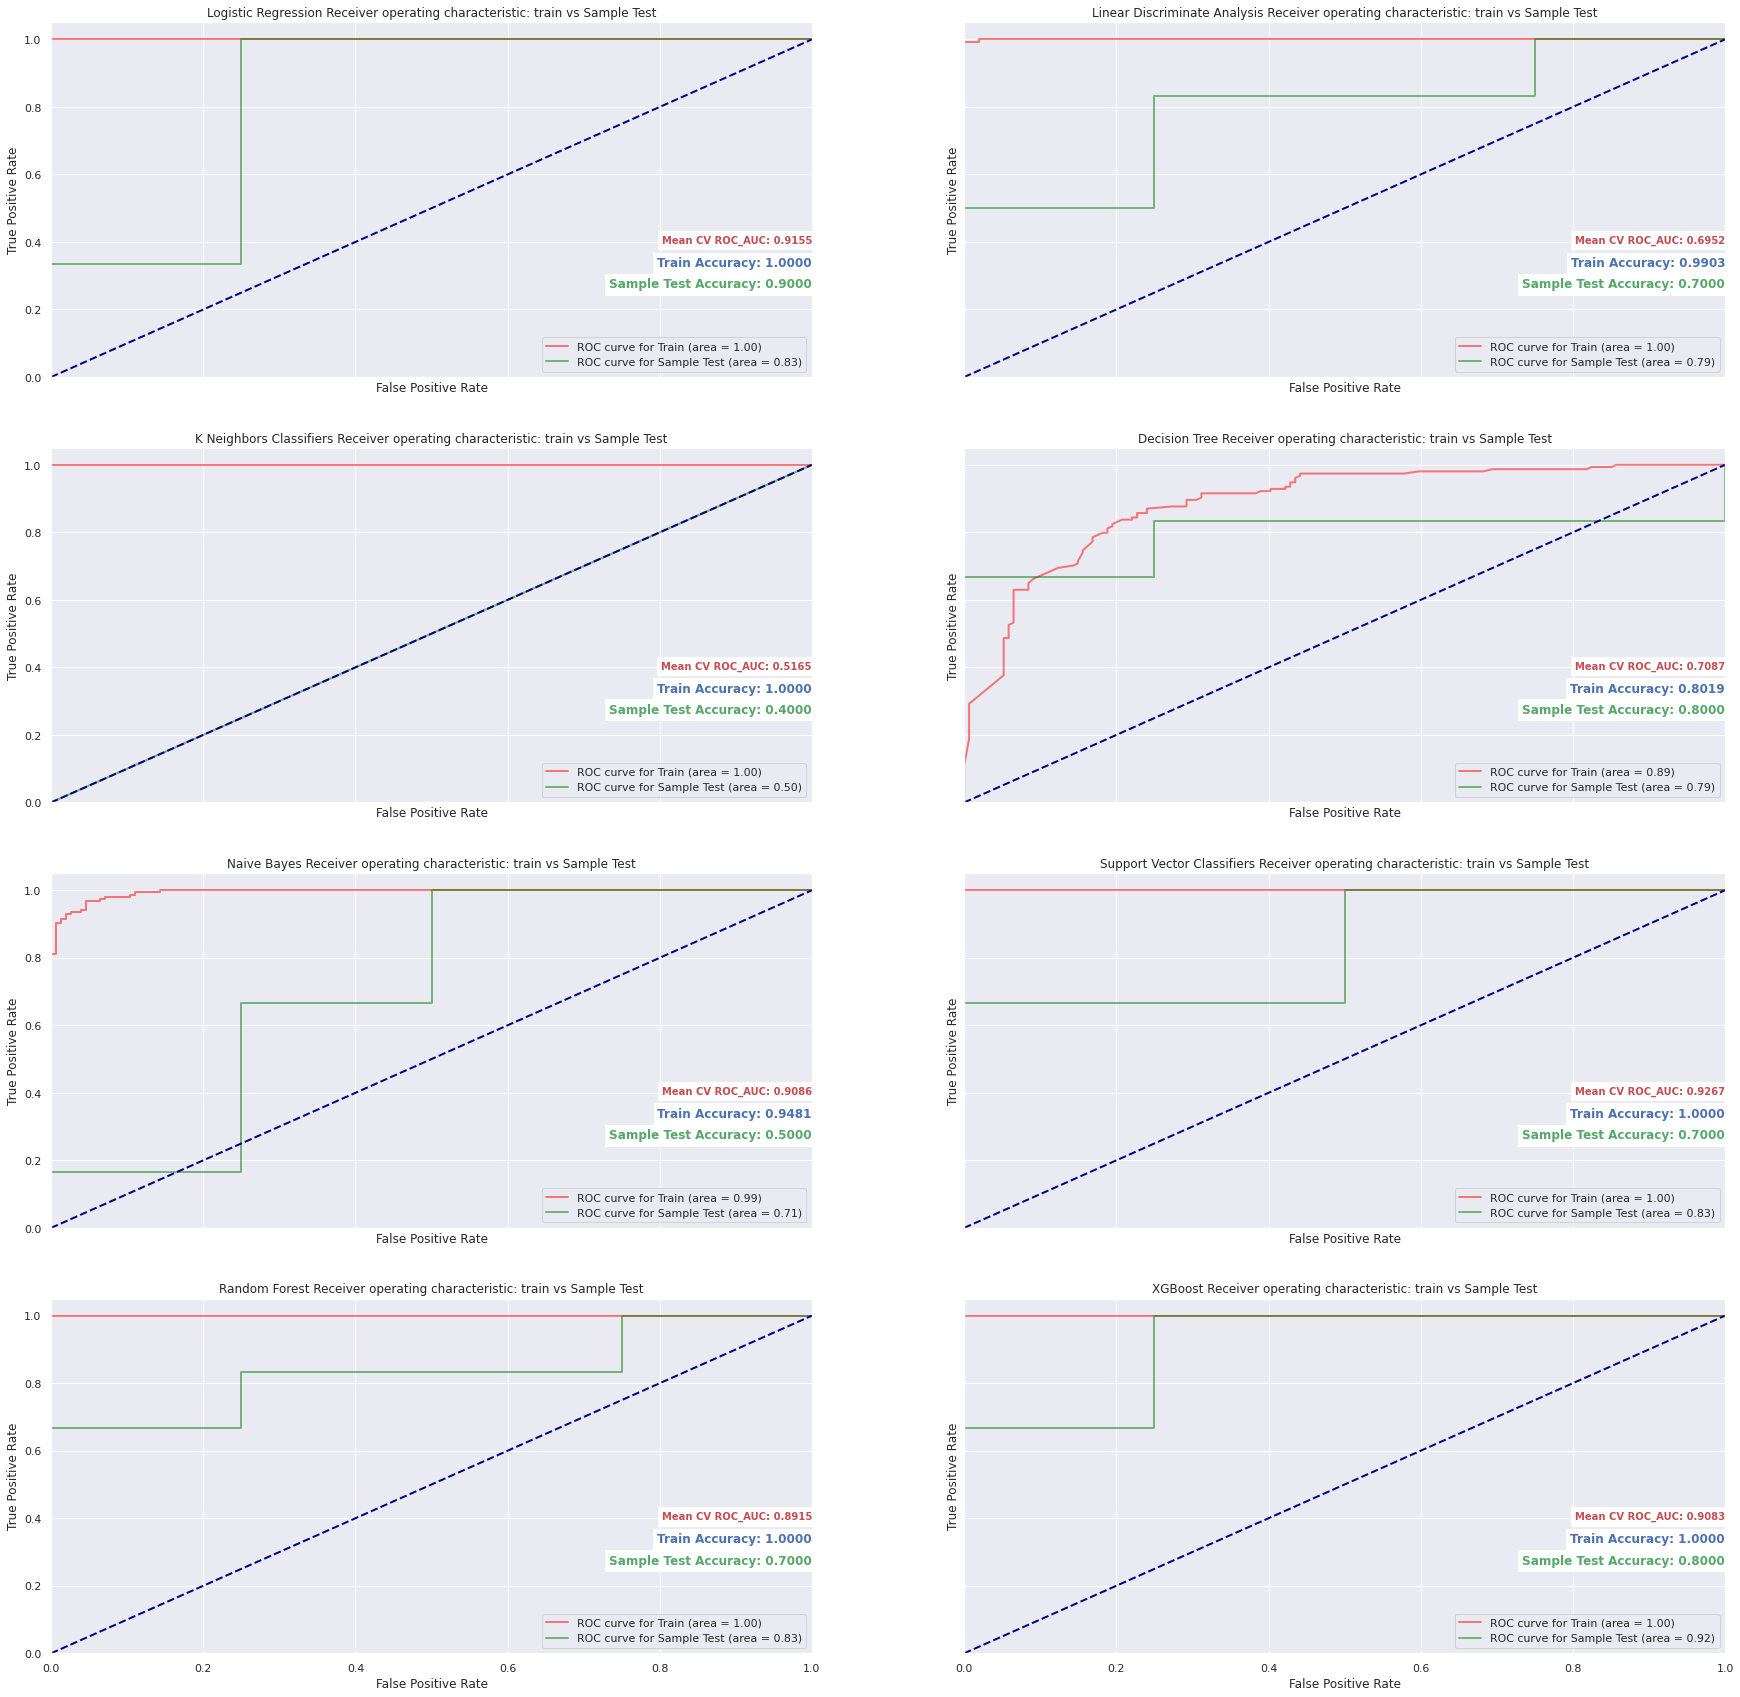

In [ ]:
overSample_best_model, OS_clfs = trainWithBestModelAndParams(Xo_train, X_test, yo_train, y_test, 'OverSample', test, CV=5)

### Results

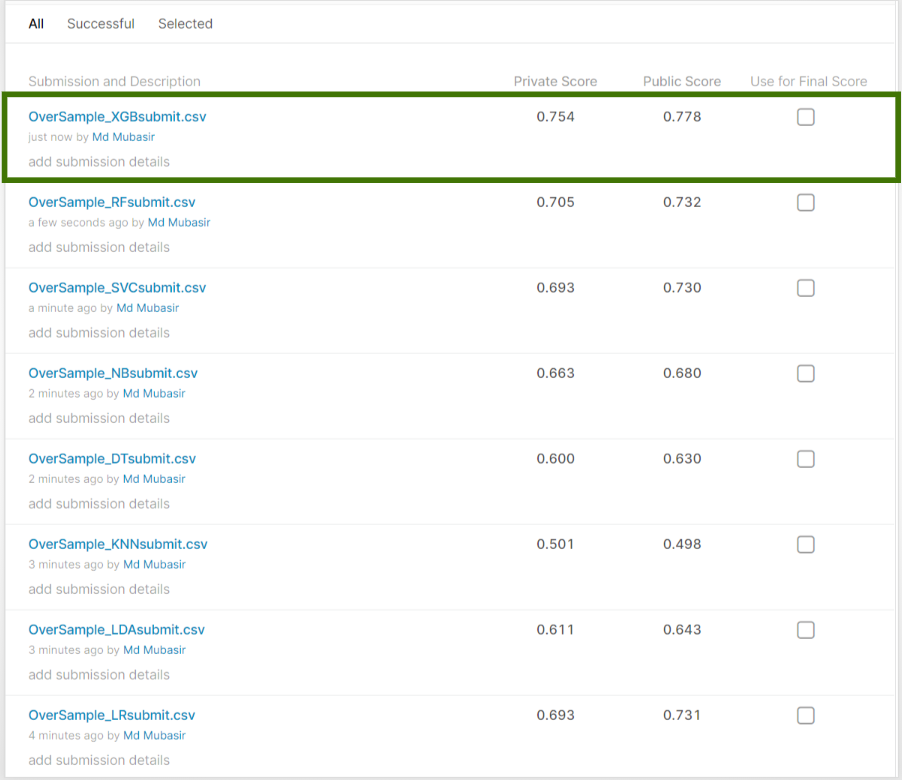

In [ ]:
Image('result/OverSample/OverSample_submissions.png')

## Over Under Sapmling

### Model

In [ ]:
smote = SMOTE(sampling_strategy=0.75)
Xo_train, yo_train = smote.fit_sample(X_train, y_train)
print(Xo_train.shape, yo_train.shape) # (269, 300) (269,)

under = RandomUnderSampler(sampling_strategy=1.0)
Xou_train, you_train = under.fit_resample(Xo_train, yo_train)
print(Xou_train.shape, you_train.shape) # (230, 300) (230,)

(269, 300) (269,)
(230, 300) (230,)


Estimator                      | Score  | Best Parameters
------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Logistic Regression            | 0.8635 | {'tol': 0.0001, 'solver': 'liblinear', 'penalty': 'l2', 'max_iter': 100, 'intercept_scaling': 4, 'class_weight': 'balanced', 'C': 100}
Linear Discriminate Analysis   | 0.5410 | {'tol': 0.0001, 'solver': 'svd'}
K Neighbors Classifiers        | 0.6679 | {'weights': 'distance', 'n_neighbors': 10, 'n_jobs': -1, 'leaf_size': 5, 'algorithm': 'kd_tree'}
Decision Tree                  | 0.6308 | {'min_samples_leaf': 50, 'max_features': None, 'max_depth': 5, 'criterion': 'gini', 'class_weight': 'balanced'}
Naive Bayes                    | 0.8461 | {'var_smoothing': 1.0}
Support Vector Classifiers     | 0.8881 | {'probability': True, 'kernel': 'rbf', 'gamma': 'auto', 'class_weight': 'balanced', 'C': 11}
Random Forest   

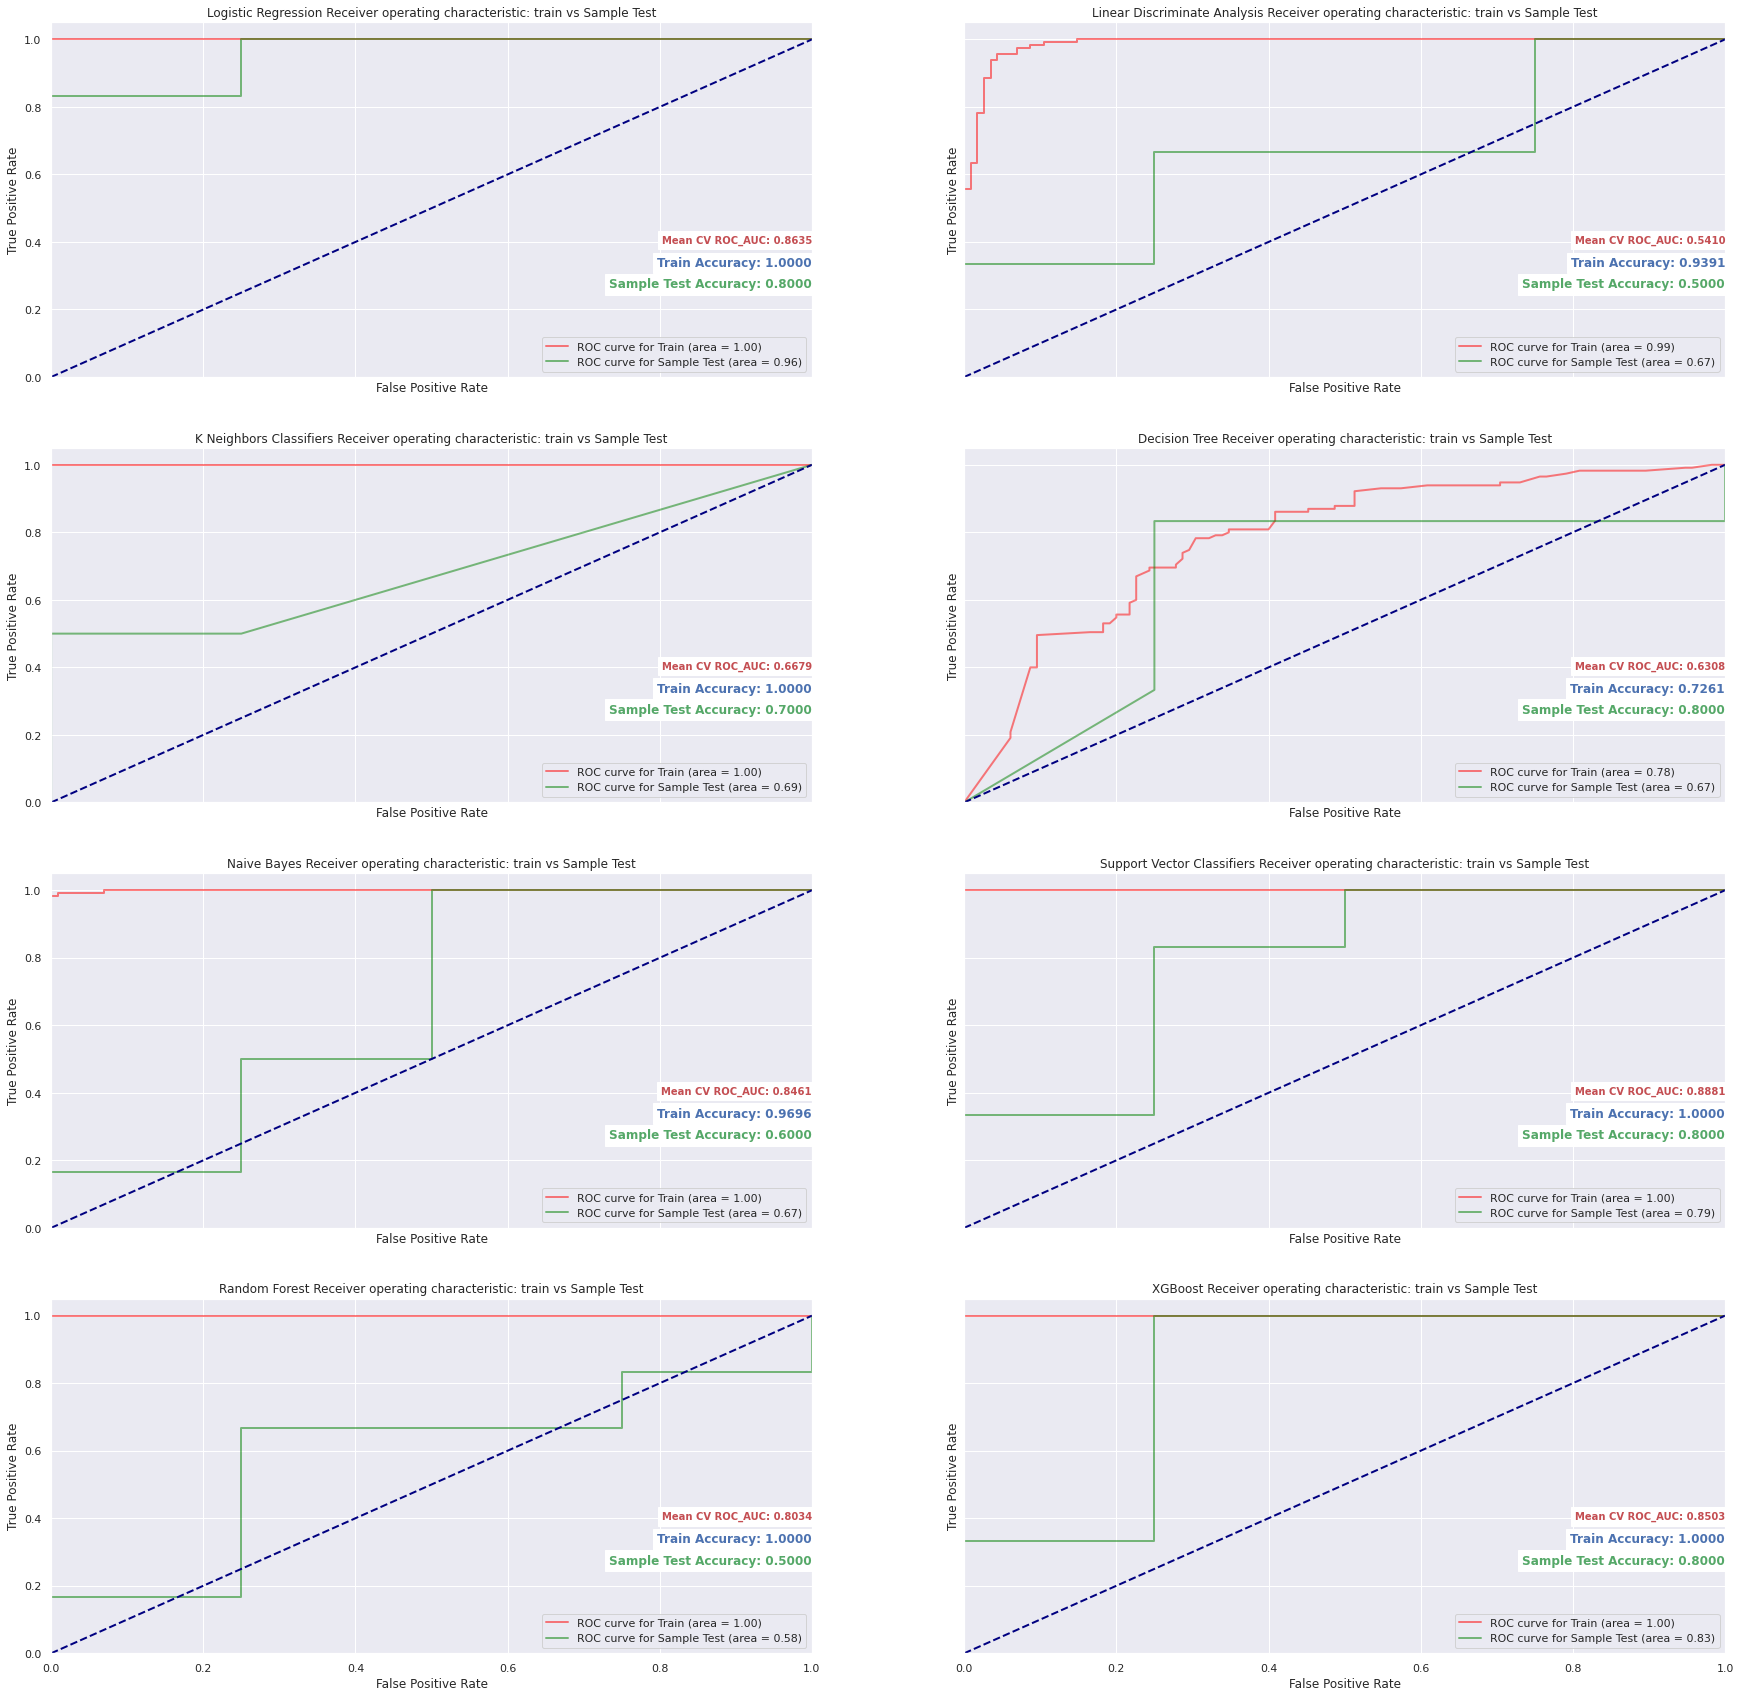

In [ ]:
overUnderSample_best_model, OUS_clfs = trainWithBestModelAndParams(Xou_train, X_test, you_train, y_test, 'OverUnderSample', test, CV=5)

### Results

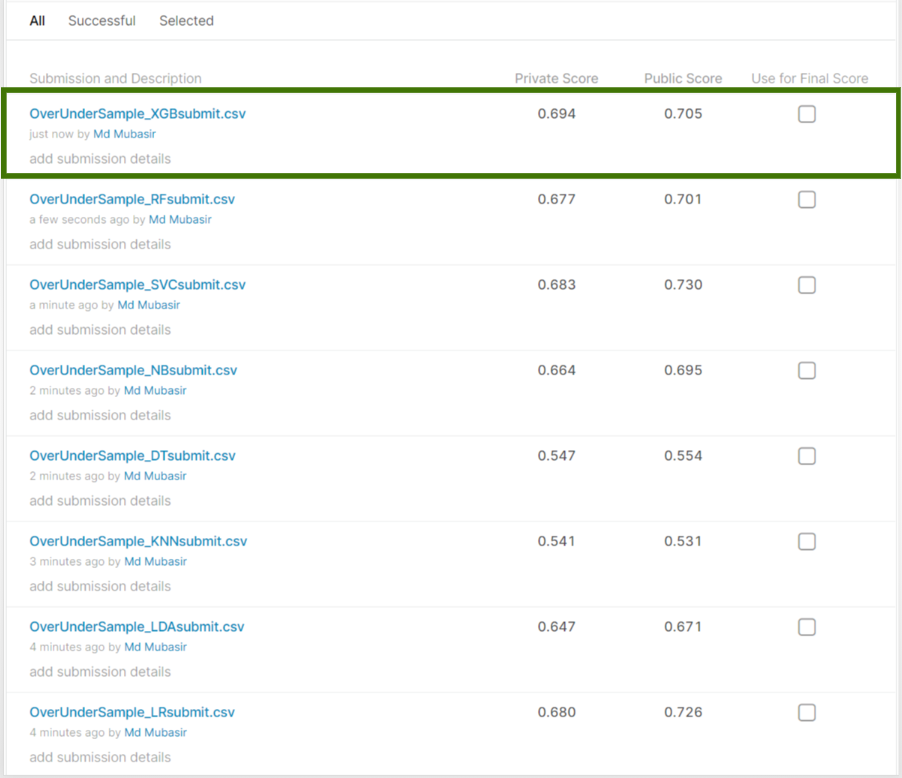

In [ ]:
Image('result/OverUnderSample/OverUnderSample_submissions.png')

# Engineered Features Model

## Model

In [ ]:
tr_ef = pd.read_csv('data/trainEngineeredFeatures.csv')
te_ef = pd.read_csv('data/testEngineeredFeatures.csv')
tr_ef.head()

id  Quantile_binning_7  ...  Quantile_binning_270  Quantile_binning_282
0   0                   2  ...                     3                     3
1   1                   2  ...                     0                     1
2   2                   1  ...                     0                     1
3   3                   3  ...                     2                     1
4   4                   3  ...                     1                     3

[5 rows x 8 columns]

In [ ]:
te_ef.head()

id  Quantile_binning_7  ...  Quantile_binning_270  Quantile_binning_282
0  250                   1  ...                     0                     2
1  251                   1  ...                     0                     0
2  252                   0  ...                     0                     2
3  253                   3  ...                     1                     1
4  254                   0  ...                     1                     1

[5 rows x 8 columns]

In [ ]:
X_ef = pd.concat([X ,pd.get_dummies(tr_ef[tr_ef.columns[1]], prefix='Qb'+tr_ef.columns[1].split('_')[2])],axis=1)
for col in tr_ef.columns[2:]:
    X_ef = pd.concat([X_ef ,pd.get_dummies(tr_ef[col], prefix='Qb'+col.split('_')[2])],axis=1)
X_ef.head()

0      1      2      3  ...  Qb282_0  Qb282_1  Qb282_2  Qb282_3
0 -0.098  2.165  0.681 -0.614  ...        0        0        0        1
1  1.081 -0.973 -0.383  0.326  ...        0        1        0        0
2 -0.523 -0.089 -0.348  0.148  ...        0        1        0        0
3  0.067 -0.021  0.392 -1.637  ...        0        1        0        0
4  2.347 -0.831  0.511 -0.021  ...        0        0        0        1

[5 rows x 328 columns]

In [ ]:
test_ef= pd.concat([test ,pd.get_dummies(te_ef[te_ef.columns[1]], prefix='Qb'+te_ef.columns[1].split('_')[2])],axis=1)
for col in te_ef.columns[2:]:
    test_ef = pd.concat([test_ef ,pd.get_dummies(te_ef[col], prefix='Qb'+col.split('_')[2])],axis=1)
test_ef.head()

0      1      2      3  ...  Qb282_0  Qb282_1  Qb282_2  Qb282_3
0  0.500 -1.033 -1.595  0.309  ...        0        0        1        0
1  0.776  0.914 -0.494  1.347  ...        1        0        0        0
2  1.750  0.509 -0.057  0.835  ...        0        0        1        0
3 -0.556 -1.855 -0.682  0.578  ...        0        1        0        0
4  0.754 -0.245  1.173 -1.623  ...        0        1        0        0

[5 rows x 328 columns]

In [ ]:
Xef_train, Xef_test, yef_train, yef_test = train_test_split(X_ef, y, test_size=0.04, stratify=y, random_state=42) 
print(Xef_train.shape, yef_train.shape) #(240, 328) (240,)
print(Xef_test.shape, yef_test.shape) # (10, 328) (10,)
print(test_ef.shape) # (19750, 328)

(240, 328) (240,)
(10, 328) (10,)
(19750, 328)


Estimator                      | Score  | Best Parameters
------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Logistic Regression            | 0.7964 | {'tol': 0.0002, 'solver': 'liblinear', 'penalty': 'l1', 'max_iter': 200, 'intercept_scaling': 4, 'class_weight': 'balanced', 'C': 100}
Linear Discriminate Analysis   | 0.7110 | {'tol': 0.0001, 'solver': 'svd'}
K Neighbors Classifiers        | 0.6238 | {'weights': 'distance', 'n_neighbors': 10, 'n_jobs': -1, 'leaf_size': 5, 'algorithm': 'kd_tree'}
Decision Tree                  | 0.6387 | {'min_samples_leaf': 50, 'max_features': None, 'max_depth': 5, 'criterion': 'gini', 'class_weight': 'balanced'}
Naive Bayes                    | 0.7435 | {'var_smoothing': 1.0}
Support Vector Classifiers     | 0.7573 | {'probability': True, 'kernel': 'rbf', 'gamma': 'auto', 'class_weight': 'balanced', 'C': 11}
Random Forest   

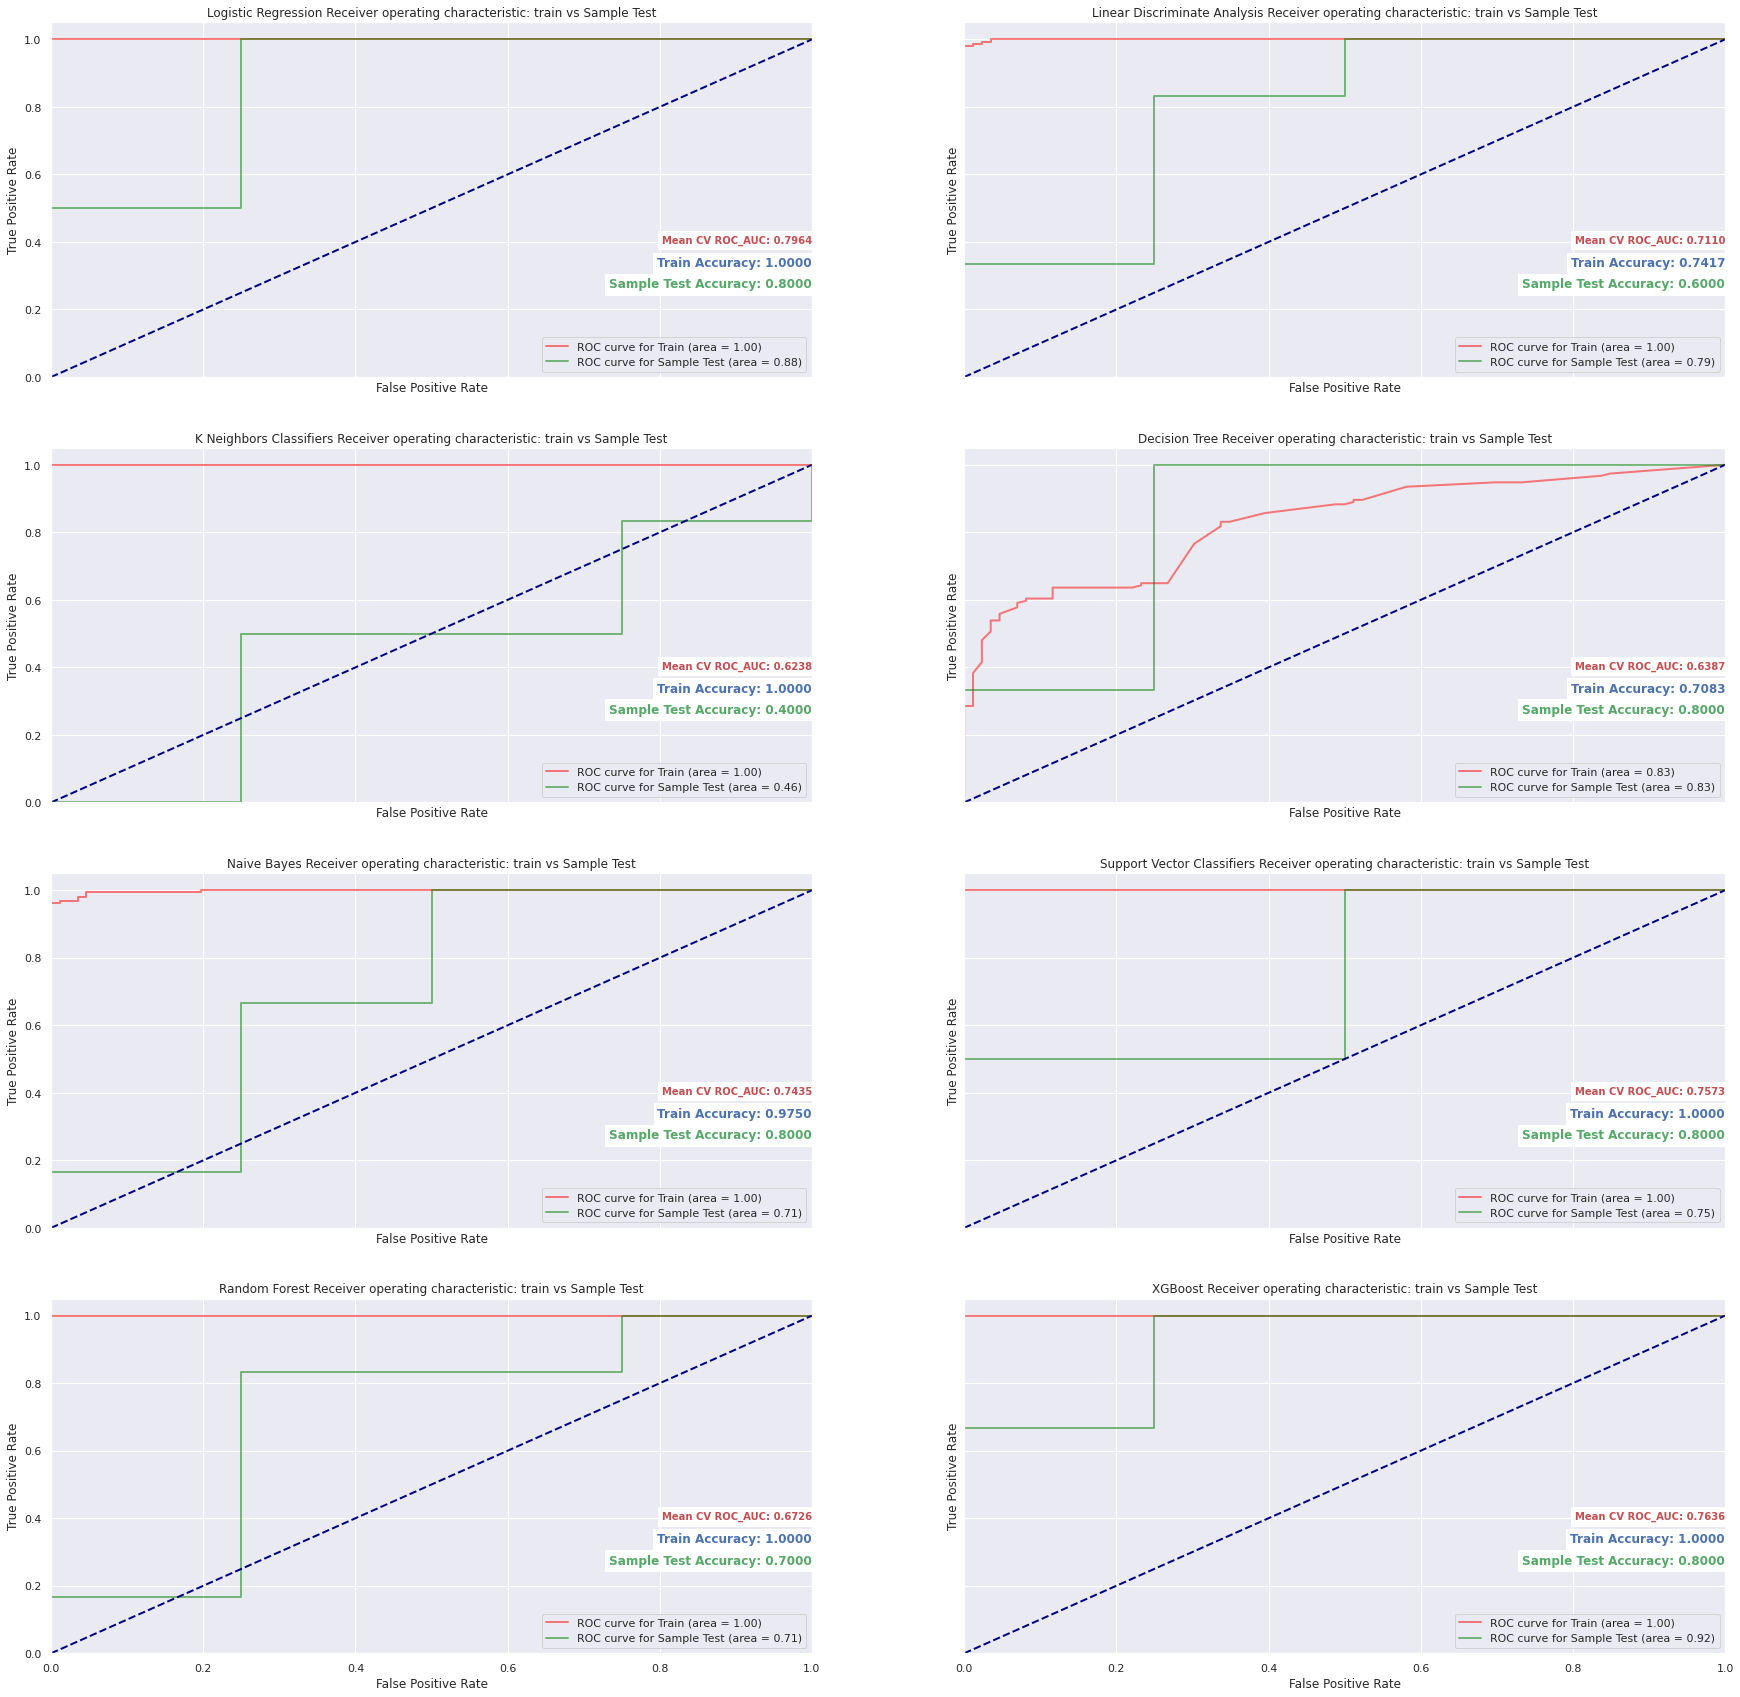

In [ ]:
EF_best_model, EF_clfs = trainWithBestModelAndParams(Xef_train, Xef_test, yef_train, yef_test, 'EngineeredF', test_ef, CV=5)

## Results

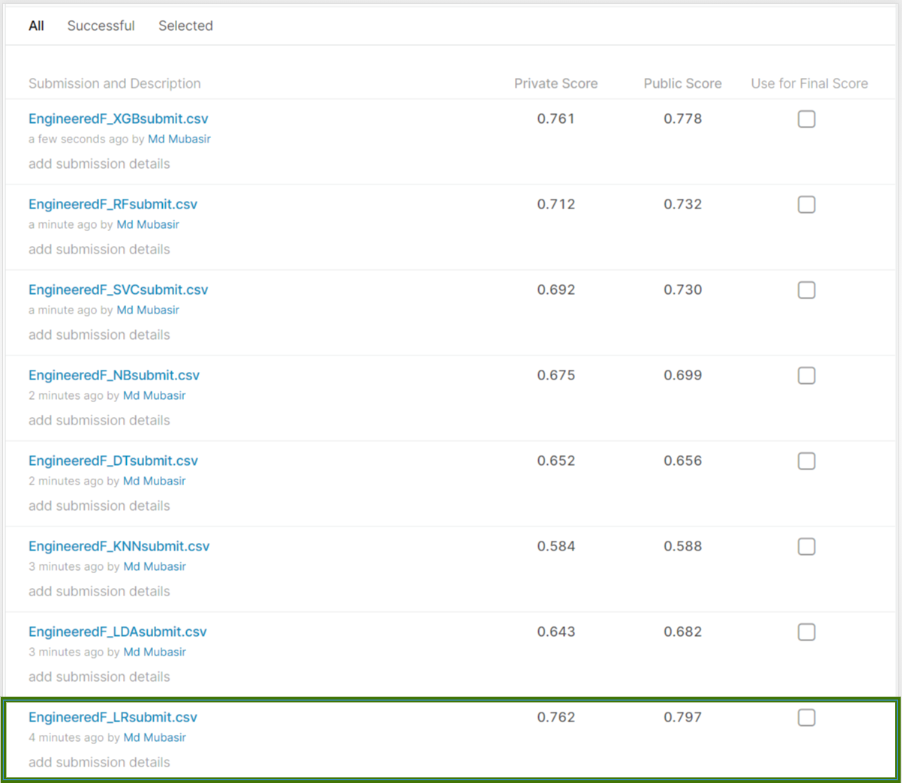

In [ ]:
Image('result/EngineeredF/EngineeredF_submissions.png')

# Features Selection Model

## Filter Methods

### Mutual Information (MI)

#### Model

In [ ]:
select_k = 20
selection = SelectKBest(mutual_info_classif, k=select_k).fit(X_train, y_train)
print('Best {} selected Features are: {}'.format(select_k, list(X_train.columns[selection.get_support()])))
# Best 20 selected Features are: ['2', '17', '33', '36', '44', '91', '92', '96', '98', '122', '130', '131', '165', '193', '219', '231', '247', '280', '289', '298']

Best 20 selected Features are: ['2', '17', '33', '36', '44', '91', '92', '96', '98', '122', '130', '131', '165', '193', '219', '231', '247', '280', '289', '298']


In [ ]:
Xmi_train = selection.transform(X_train)
Xmi_test = selection.transform(X_test)
test_mi = selection.transform(test)
print(Xmi_train.shape, y_train.shape) #(240, 20) (240,)
print(Xmi_test.shape, y_test.shape) #(10, 20) (10,)
print(test_mi.shape) #(19750, 20)

(240, 20) (240,)
(10, 20) (10,)
(19750, 20)


Estimator                      | Score  | Best Parameters
------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Logistic Regression            | 0.7351 | {'tol': 0.0002, 'solver': 'liblinear', 'penalty': 'l1', 'max_iter': 200, 'intercept_scaling': 1, 'class_weight': 'balanced', 'C': 0.1}
Linear Discriminate Analysis   | 0.6930 | {'tol': 0.0001, 'solver': 'svd'}
K Neighbors Classifiers        | 0.6595 | {'weights': 'distance', 'n_neighbors': 6, 'n_jobs': -1, 'leaf_size': 2, 'algorithm': 'auto'}
Decision Tree                  | 0.6483 | {'min_samples_leaf': 50, 'max_features': None, 'max_depth': 5, 'criterion': 'gini', 'class_weight': 'balanced'}
Naive Bayes                    | 0.7202 | {'var_smoothing': 1.0}
Support Vector Classifiers     | 0.7243 | {'probability': True, 'kernel': 'rbf', 'gamma': 0.0001, 'class_weight': 'balanced', 'C': 200}
Random Forest      

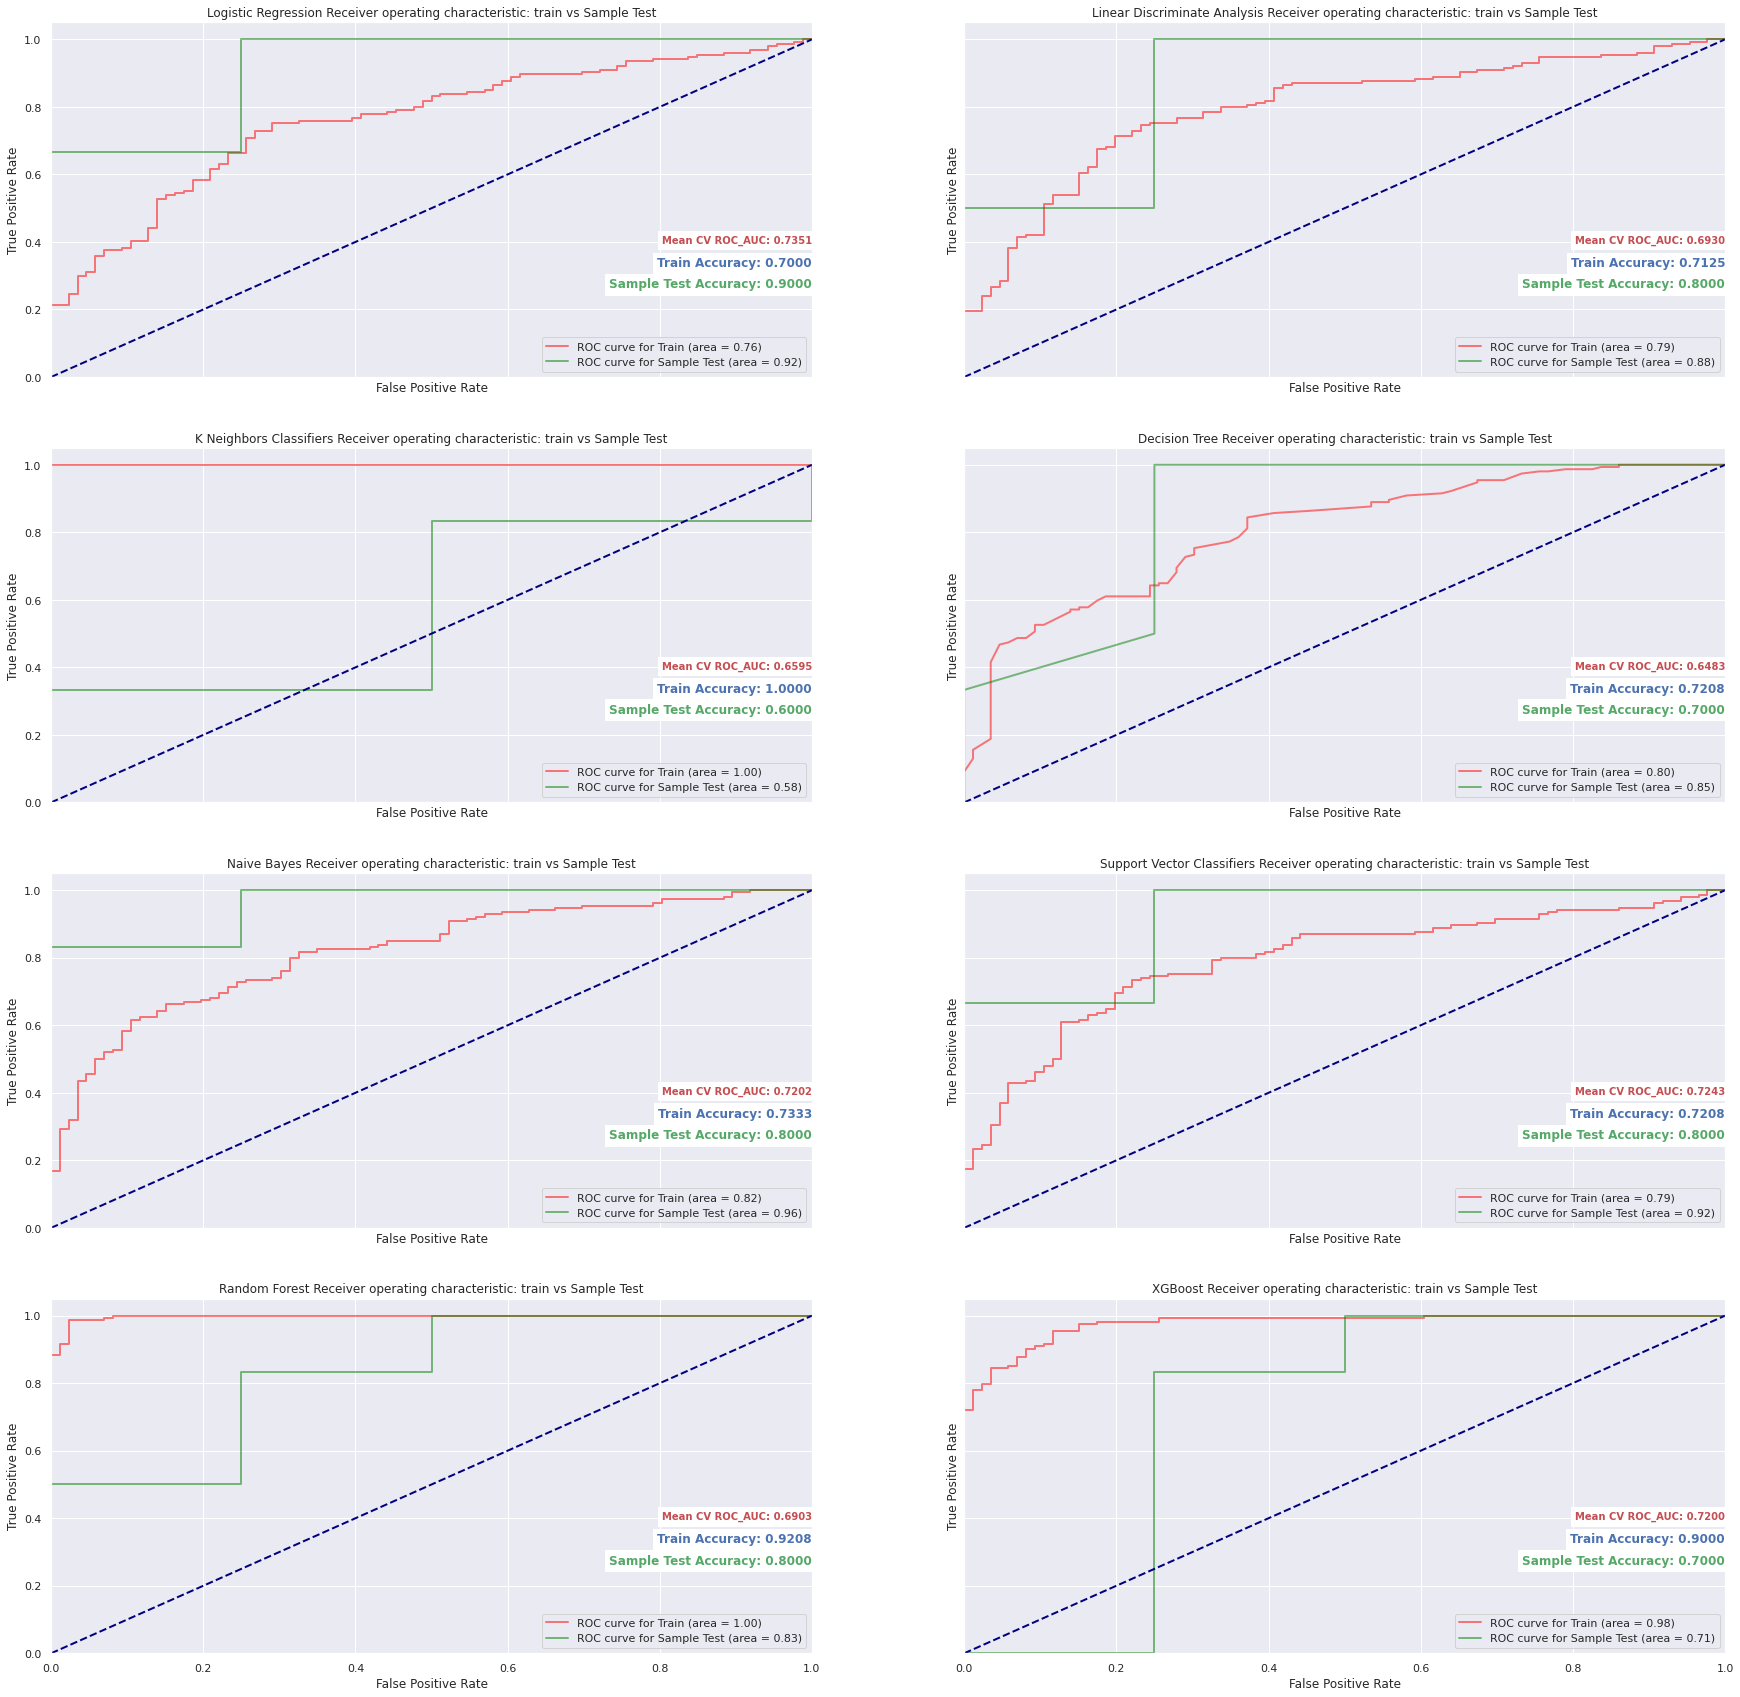

In [ ]:
MI_best_model, MI_clfs = trainWithBestModelAndParams(Xmi_train, Xmi_test, y_train, y_test, 'MI', test_mi, CV=5)

#### Results

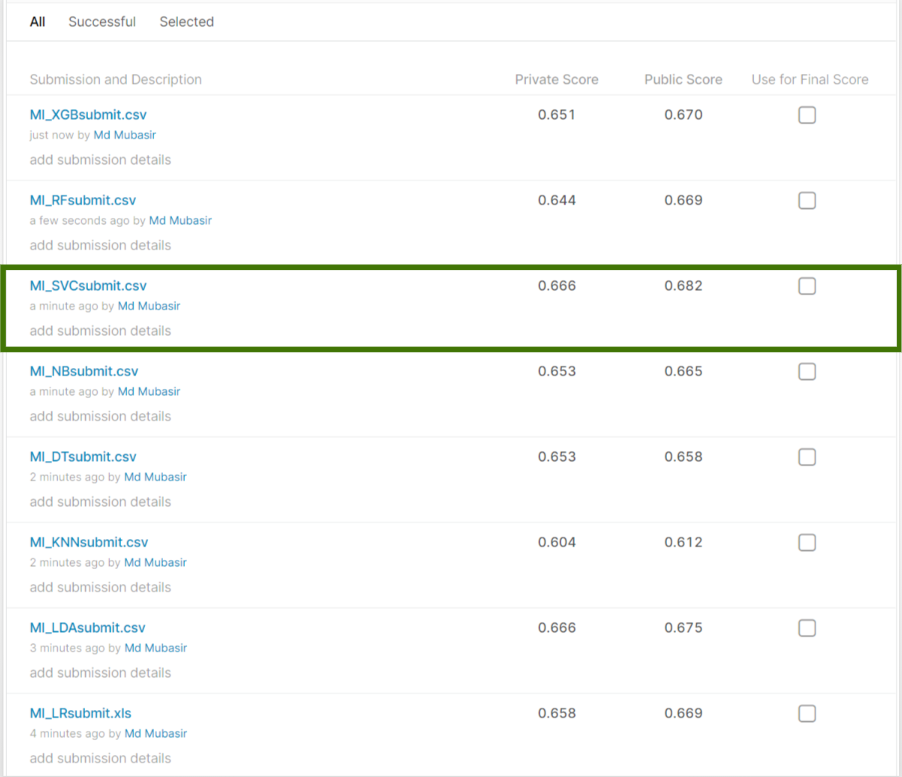

In [ ]:
Image('result/MI/MI_submissions.png')

## Wrapper methods

### Sequential Forward Selection SFS

#### Model

In [ ]:
def SequentialForwardSelection(X_train, y_train, Floating=False):
    '''
    Select important features using SFS technique and LinearSVC classifiers
    X_train: train data
    y_train: train label
    Floating: add Foalting or not

    Return:
    Selector object
    '''
    # Scaling Features
    scale = StandardScaler()
    Xsfs_train = scale.fit_transform(X_train)

    # Define LinearSVC parameters
    svc = LinearSVC(C=0.01, tol=0.0001, verbose=0, random_state=101, max_iter=2000, dual=False)
    # calibrated classifier
    sigmoid = CalibratedClassifierCV(svc, cv=10, method='sigmoid')

    # Select between 10 and 20 features starting from 1
    sfs = SFS(sigmoid,
        k_features=(10, 20),
        forward=True,
        floating=Floating,
        scoring='roc_auc',
        cv=list(StratifiedKFold(n_splits=10, shuffle=True, random_state=42).split(Xsfs_train,y_train)),
        n_jobs=-1
    )

    sfs.fit(Xsfs_train, y_train, custom_feature_names=X_train.columns)
    sns.set(rc={'figure.figsize':(30,10)})
    fig = plot_sfs(sfs.get_metric_dict(), kind='std_dev')
    plt.title('Sequential Forward Selection')
    plt.grid()
    plt.show()

    return sfs

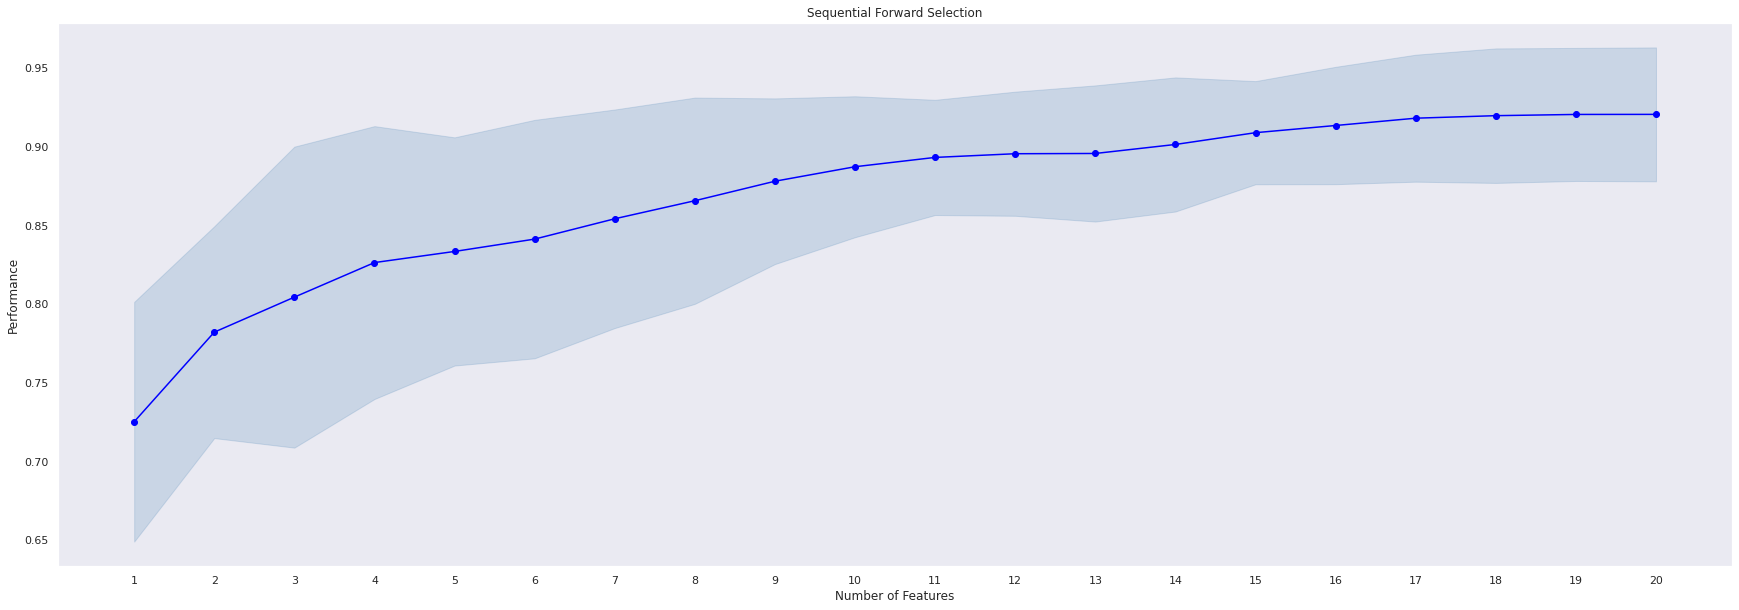

Top 20 features From SFS are : ['7', '13', '30', '33', '43', '65', '101', '106', '129', '133', '182', '217', '226', '227', '252', '257', '269', '285', '286', '295']


In [ ]:
sfs = SequentialForwardSelection(X_train, y_train)
print('Top {} features From SFS are : {}'.format(len(sfs.k_feature_names_), list(sfs.k_feature_names_))) 
# Top 20 features From SFS are : ['7', '13', '30', '33', '43', '65', '101', '106', '129', '133', '182', '217', '226', '227', '252', '257', '269', '285', '286', '295']


In [ ]:
Xsfs_train = sfs.transform(X_train)
Xsfs_test = sfs.transform(X_test)
test_sfs = sfs.transform(test)
print(Xsfs_train.shape, y_train.shape) #(240, 20) (240,)
print(Xsfs_test.shape, y_test.shape) #(10, 20) (10,)
print(test_sfs.shape) #(19750, 20)

(240, 20) (240,)
(10, 20) (10,)
(19750, 20)


Estimator                      | Score  | Best Parameters
------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Logistic Regression            | 0.8709 | {'tol': 0.0001, 'solver': 'liblinear', 'penalty': 'l2', 'max_iter': 100, 'intercept_scaling': 3, 'class_weight': 'balanced', 'C': 0.1}
Linear Discriminate Analysis   | 0.8720 | {'tol': 0.0001, 'solver': 'svd'}
K Neighbors Classifiers        | 0.7138 | {'weights': 'distance', 'n_neighbors': 10, 'n_jobs': -1, 'leaf_size': 5, 'algorithm': 'kd_tree'}
Decision Tree                  | 0.6702 | {'min_samples_leaf': 50, 'max_features': None, 'max_depth': 5, 'criterion': 'gini', 'class_weight': 'balanced'}
Naive Bayes                    | 0.8538 | {'var_smoothing': 1.0}
Support Vector Classifiers     | 0.8712 | {'probability': True, 'kernel': 'rbf', 'gamma': 0.0001, 'class_weight': 'balanced', 'C': 200}
Random Forest  

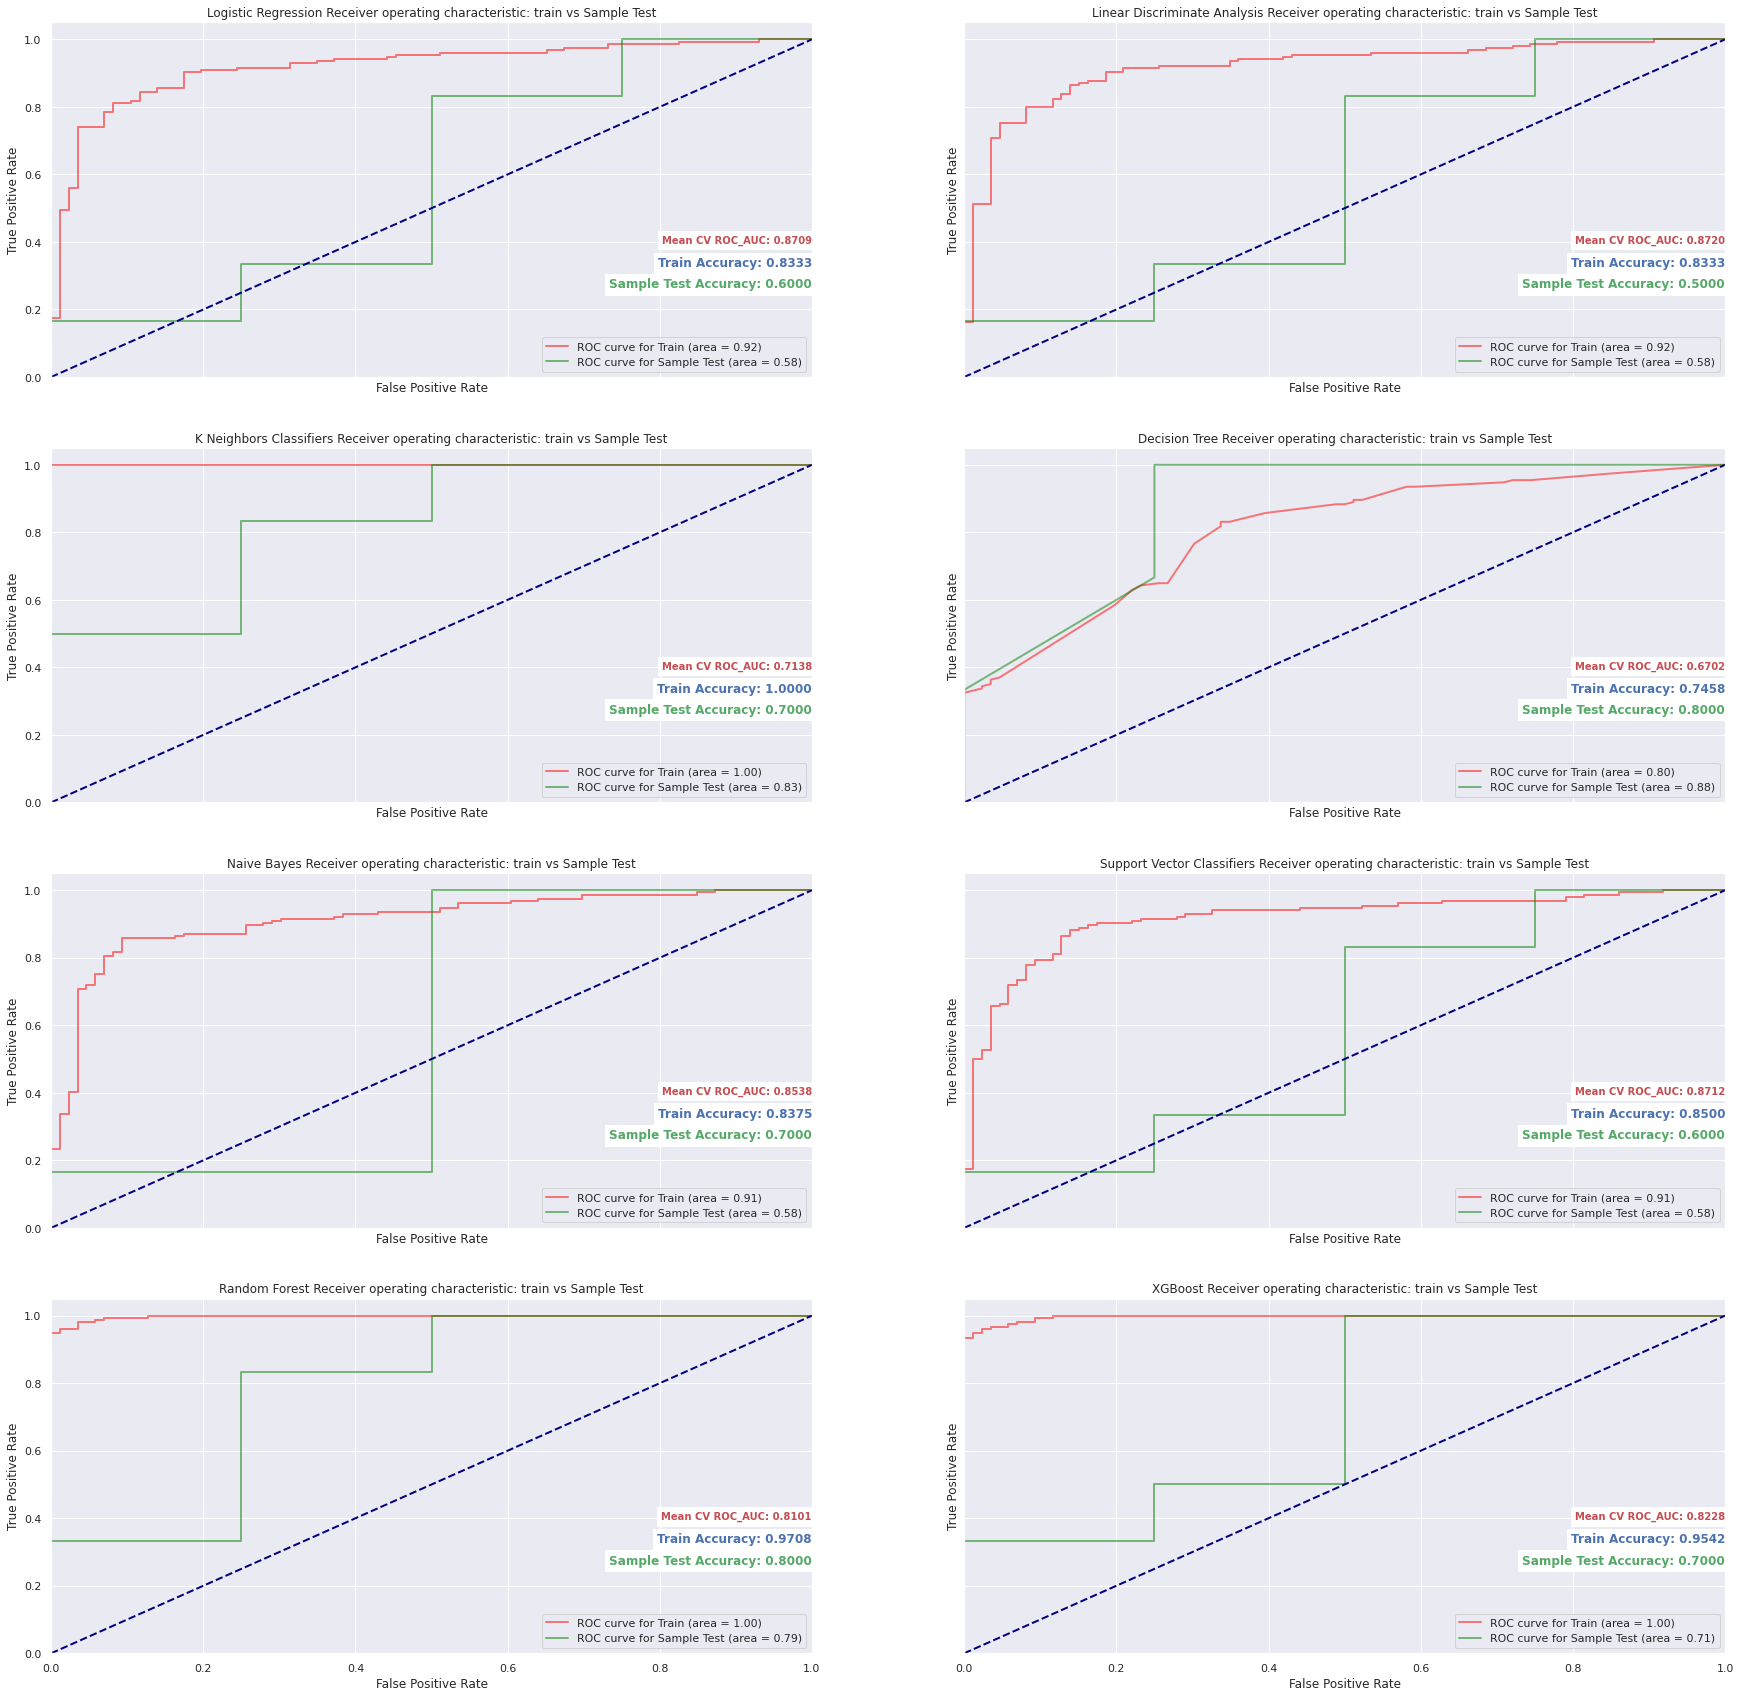

In [ ]:
SFS_best_model, SFS_clfs = trainWithBestModelAndParams(Xsfs_train, Xsfs_test, y_train, y_test, 'SFS', test_sfs, CV=5)

#### Results

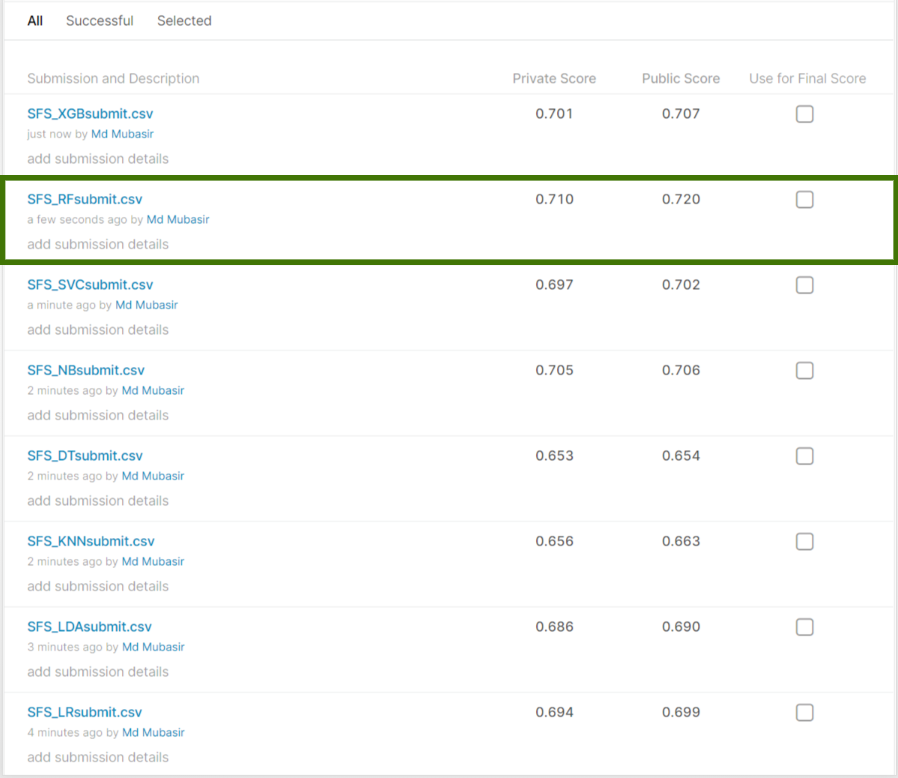

In [ ]:
Image('result/SFS/SFS_submissions.png')

### Sequential Forward Floating Selection SFFS

#### Model

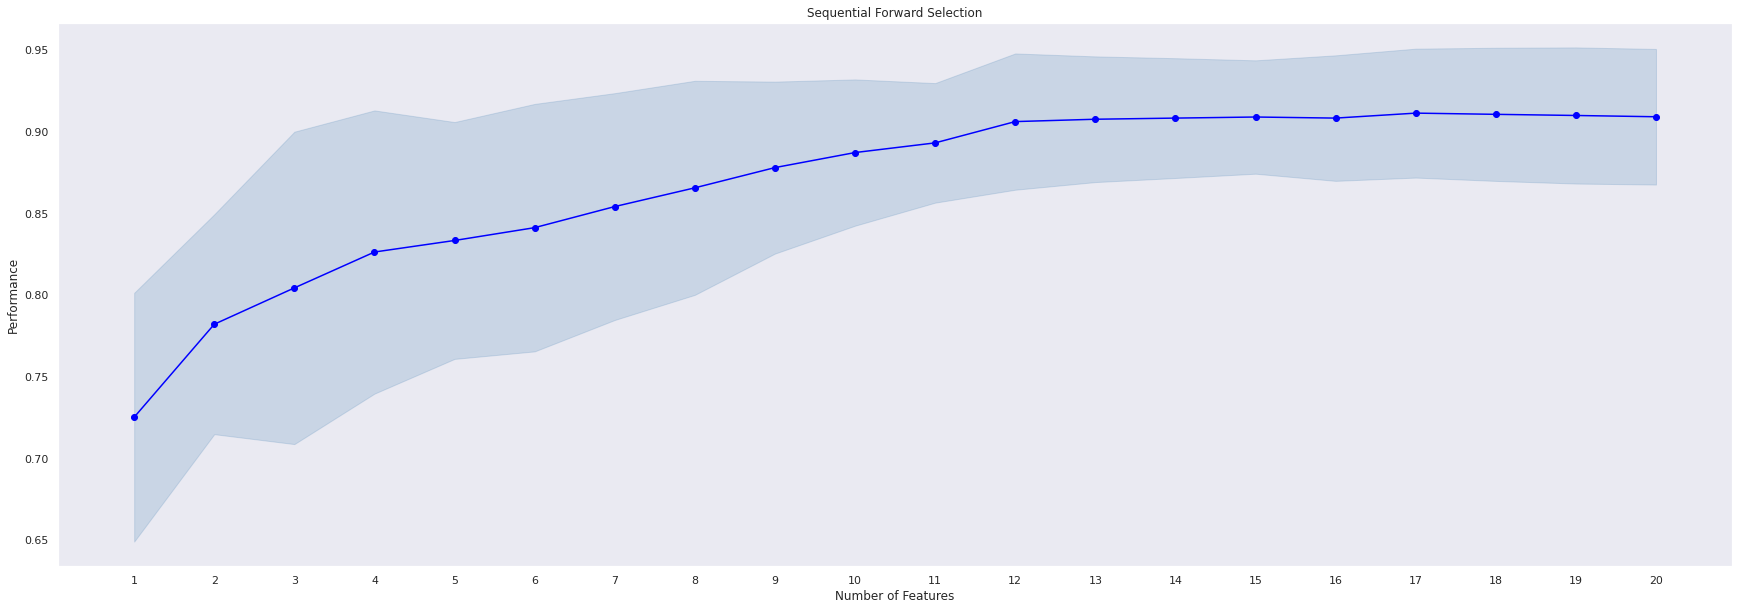

Top 17 features From SFFS are : ['19', '33', '43', '65', '92', '101', '123', '129', '133', '190', '217', '226', '227', '252', '257', '270', '295']


In [ ]:
sffs = SequentialForwardSelection(X_train, y_train, Floating=True)
print('Top {} features From SFFS are : {}'.format(len(sffs.k_feature_names_),list(sffs.k_feature_names_)))
# Top 17 features From SFFS are : ['19', '33', '43', '65', '92', '101', '123', '129', '133', '190', '217', '226', '227', '252', '257', '270', '295']

In [ ]:
Xsffs_train = sffs.transform(X_train)
Xsffs_test = sffs.transform(X_test)
test_sffs = sffs.transform(test)
print(Xsffs_train.shape, y_train.shape) # (240, 17) (240,)
print(Xsffs_test.shape, y_test.shape) # (10, 17) (10,)
print(test_sffs.shape) # (19750, 17)

(240, 17) (240,)
(10, 17) (10,)
(19750, 17)


Estimator                      | Score  | Best Parameters
------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Logistic Regression            | 0.8781 | {'tol': 0.0003, 'solver': 'liblinear', 'penalty': 'l2', 'max_iter': 300, 'intercept_scaling': 2, 'class_weight': 'balanced', 'C': 100}
Linear Discriminate Analysis   | 0.8739 | {'tol': 0.0001, 'solver': 'svd'}
K Neighbors Classifiers        | 0.7058 | {'weights': 'distance', 'n_neighbors': 10, 'n_jobs': -1, 'leaf_size': 5, 'algorithm': 'kd_tree'}
Decision Tree                  | 0.7143 | {'min_samples_leaf': 50, 'max_features': None, 'max_depth': 5, 'criterion': 'gini', 'class_weight': 'balanced'}
Naive Bayes                    | 0.8551 | {'var_smoothing': 1.0}
Support Vector Classifiers     | 0.8933 | {'probability': True, 'kernel': 'linear', 'gamma': 0.01, 'class_weight': 'balanced', 'C': 7}
Random Forest   

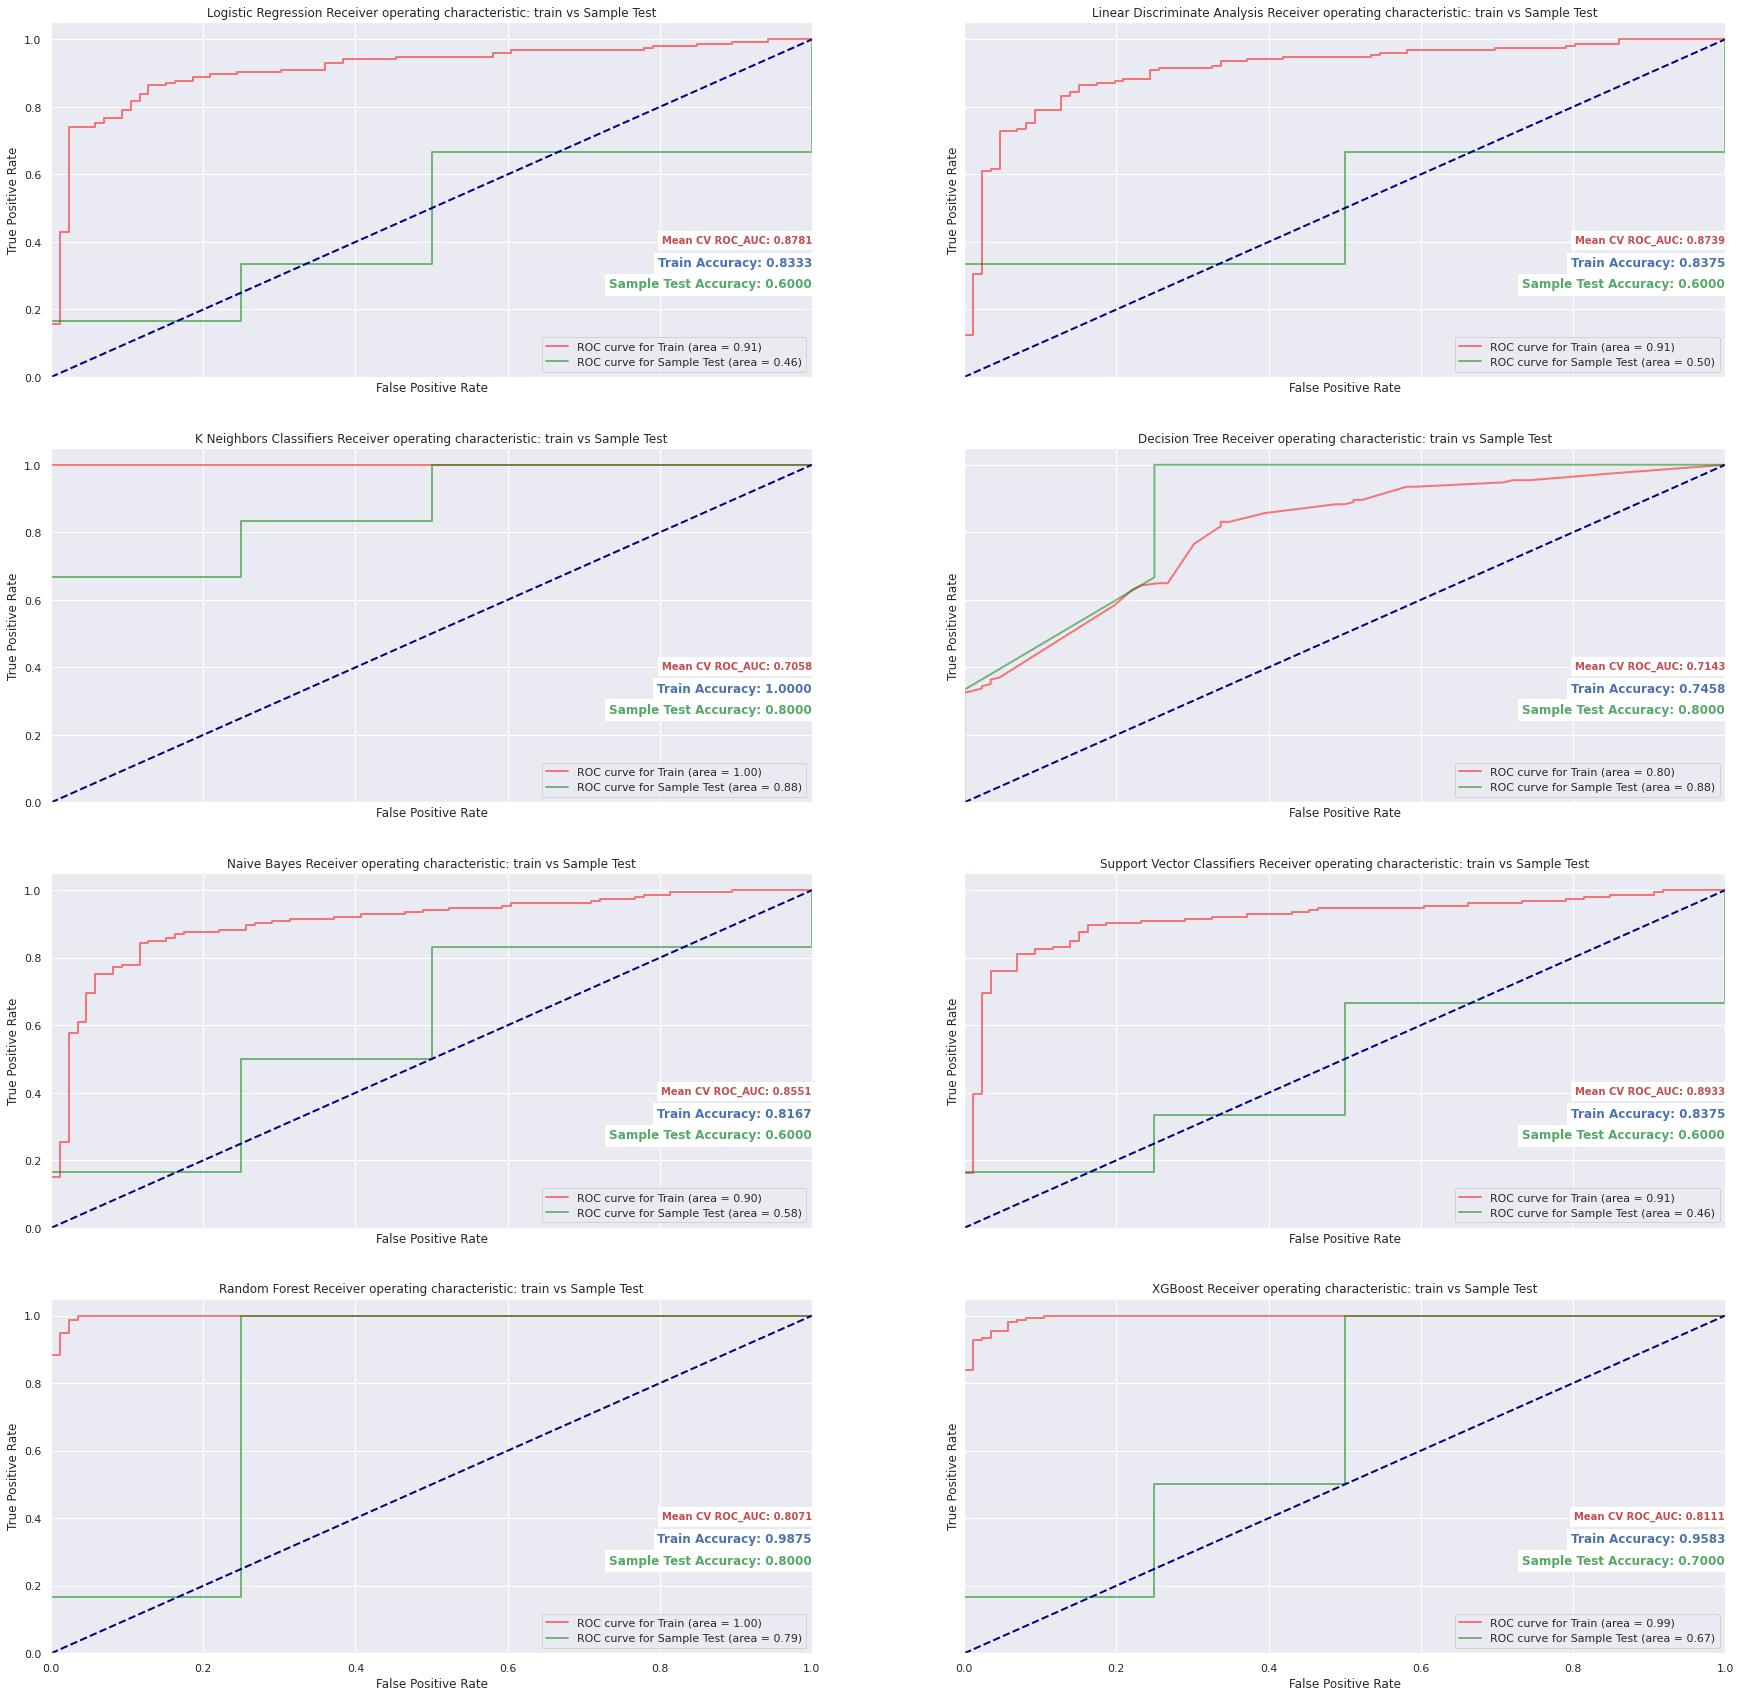

In [ ]:
SFFS_best_model, SFFS_clfs = trainWithBestModelAndParams(Xsffs_train, Xsffs_test, y_train, y_test, 'SFFS', test_sffs, CV=10)

#### Results

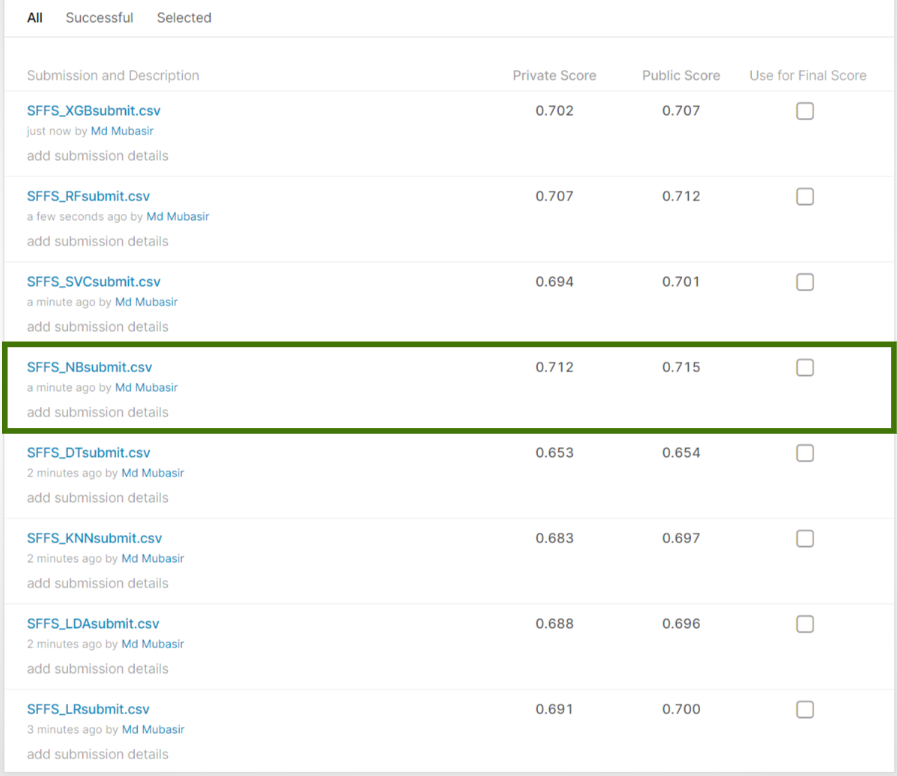

In [ ]:
Image('result/SFFS/SFFS_submissions.png')

### Recursive Feature Elimination (RFE)

#### Model

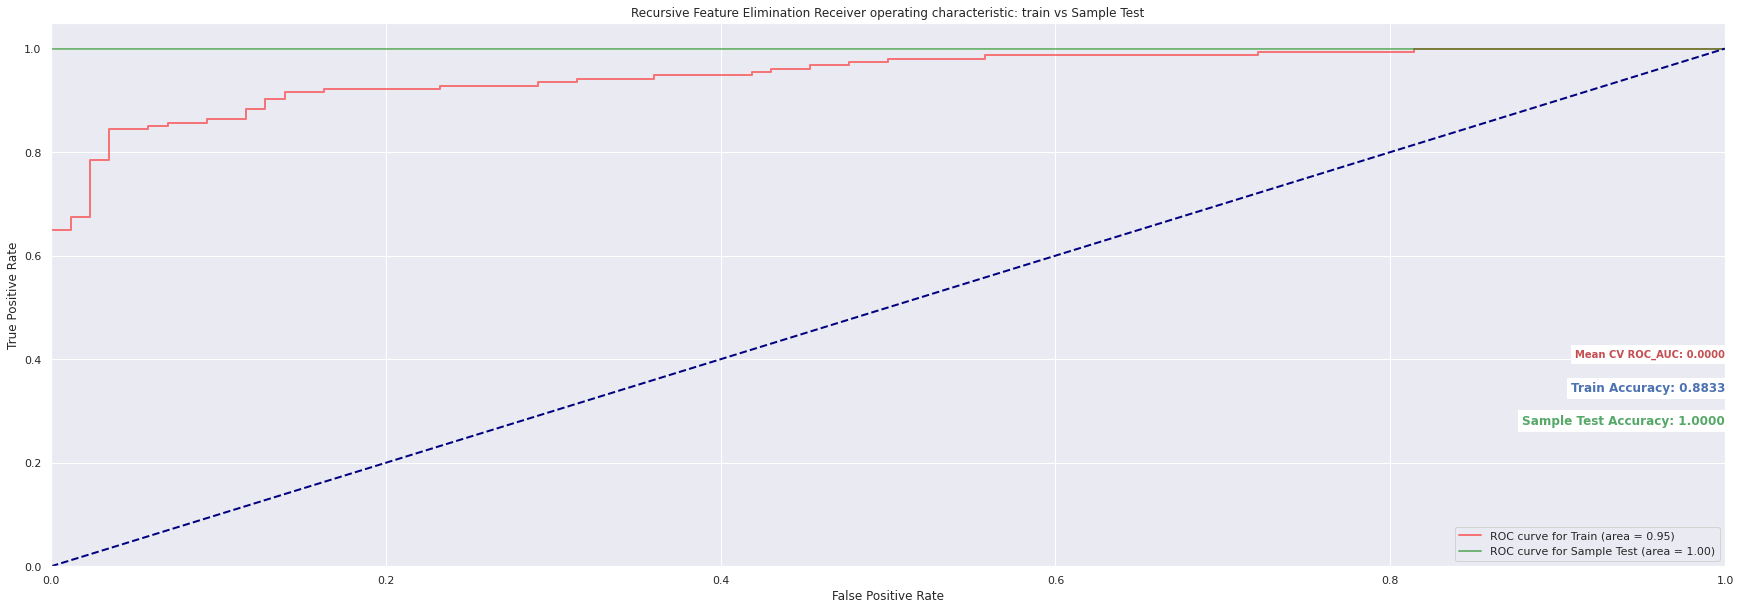

In [ ]:
Modeltype = 'RFE'
Modelname = baseline_best_model[4]

#Scaling
scl = StandardScaler()
Xrfe = scl.fit_transform(X)
Xrfe_train, Xrfe_test, test_rfe = scale(X_train, X_test, test)

#Fitting to baseline model
clf = baseline_best_model[3]
clf.fit(Xrfe,y)

#Feature Selection using RFE
selector = RFE(clf, 25, step=1)
selector.fit(Xrfe,y)

#plot ROC curve
_, ax = plt.subplots(1,1)
sns.set(rc={'figure.figsize':(30,10)})
plot_roc(y_train, selector.predict_proba(Xrfe_train), y_test, selector.predict_proba(Xrfe_test), ax,'Recursive Feature Elimination', \
         0.00, selector.score(Xrfe_train,y_train), selector.score(Xrfe_test, y_test), n_classes=2)

#Saving Model into Drive
filename = 'BestModel.sav'
joblib.dump(selector, filename)

pred = selector.predict_proba(test_rfe)[:,1]

#Saving prediction into disk
save_test_result(pred, Modeltype, Modelname)

#### Results

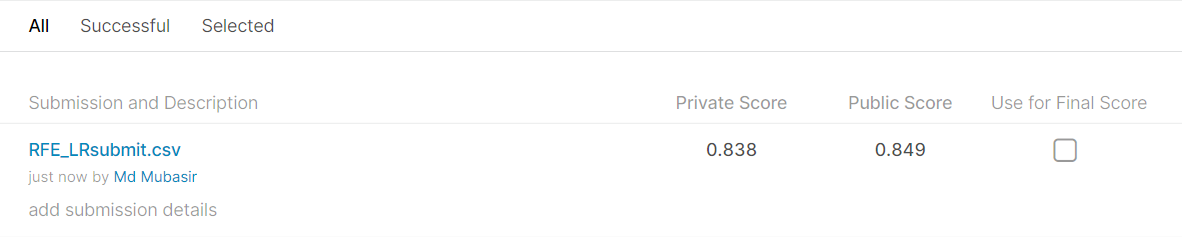

In [ ]:
Image('result/RFE/RFE_submissions.png')

## Embedded *Methods*

### Model

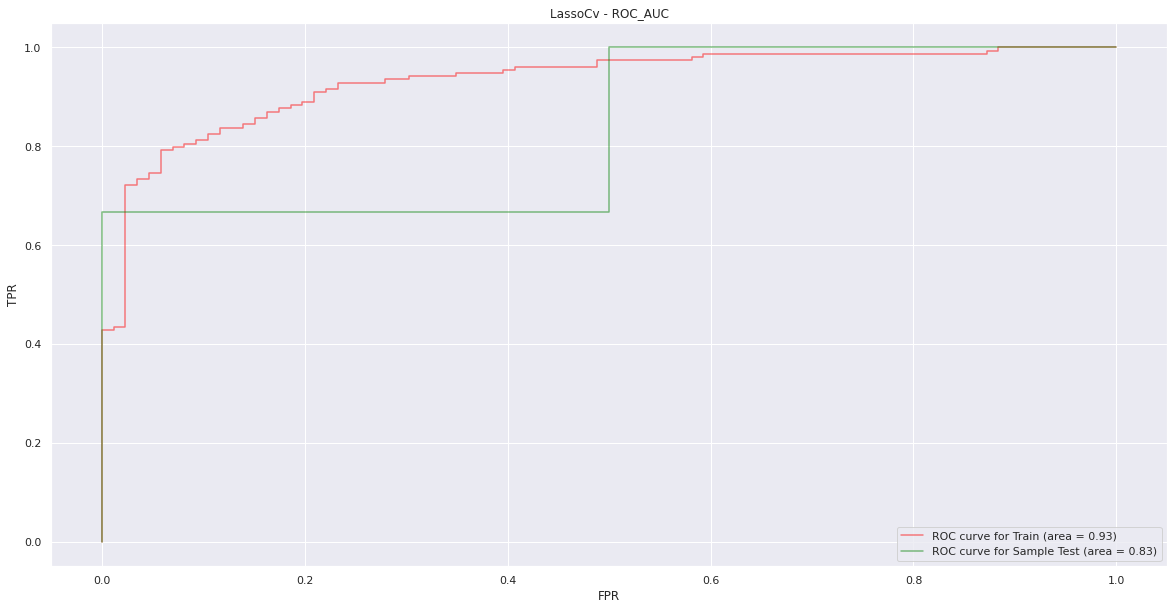

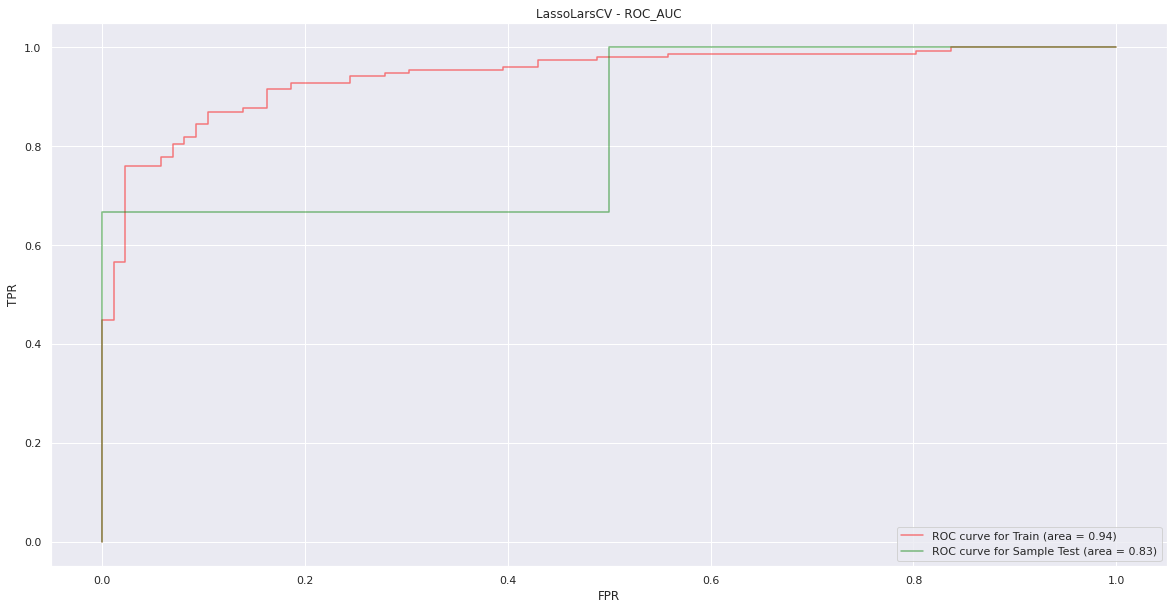

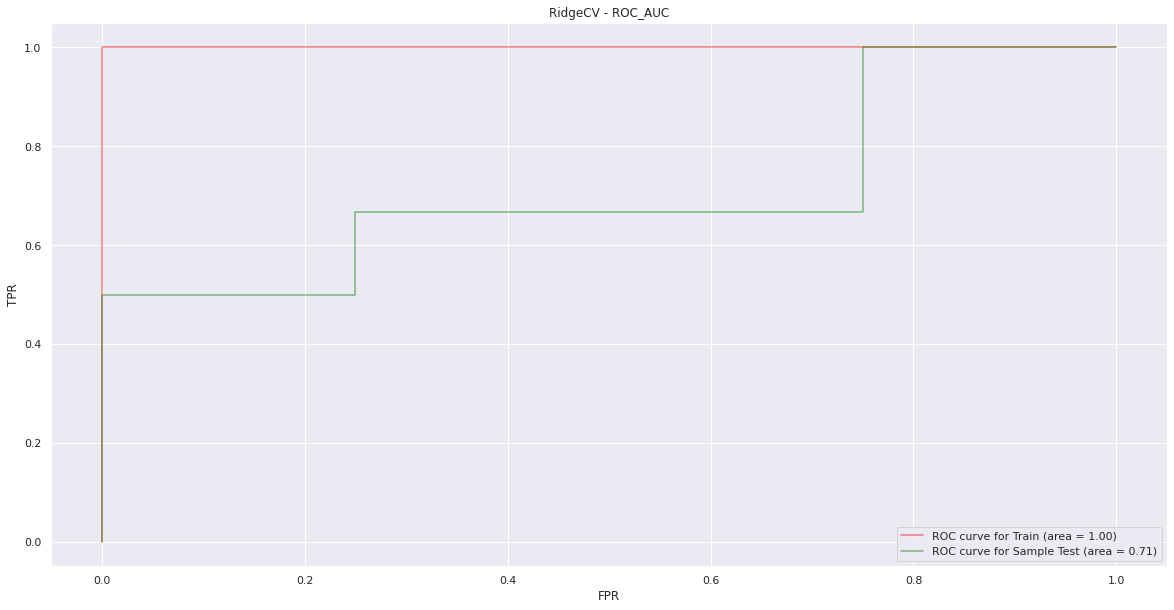

In [ ]:
embd_models =  [
    ('LassoCv' , LassoCV(alphas =  [0.05, 0.1, 0.3, 1, 3, 5, 10, 15, 30, 50, 75], n_jobs=-1) ),
    ('LassoLarsCV', LassoLarsCV(n_jobs=-1) ),
    ('RidgeCV', RidgeCV() )
]

Modeltype = 'EmbeddedF'

for model in embd_models:
    clf = model[1]
    clf.fit(X_train, y_train)
    pred = clf.predict(test)

    #Saving prediction into disk
    save_test_result(pred, Modeltype, model[0])

    #plot ROC_AUC
    y_train_pred = clf.predict(X_train)
    y_test_pred = clf.predict(X_test)

    tr_fpr, tr_tpr, _ = roc_curve(y_train,  y_train_pred)
    te_fpr, te_tpr, _ = roc_curve(y_test,  y_test_pred)

    tr_auc = roc_auc_score(y_train, y_train_pred)
    te_auc = roc_auc_score(y_test, y_test_pred)
    sns.set(rc={'figure.figsize':(20,10)})
    plt.plot(tr_fpr,tr_tpr,label='ROC curve for Train (area = %0.2f)' % tr_auc, alpha=0.5, color='red')
    plt.plot(te_fpr,te_tpr,label='ROC curve for Sample Test (area = %0.2f)' % te_auc, alpha=0.5, color='green')
    plt.title(model[0]+' - ROC_AUC')
    plt.xlabel('FPR')
    plt.ylabel('TPR')
    plt.legend(loc=4)
    plt.show()

### Results

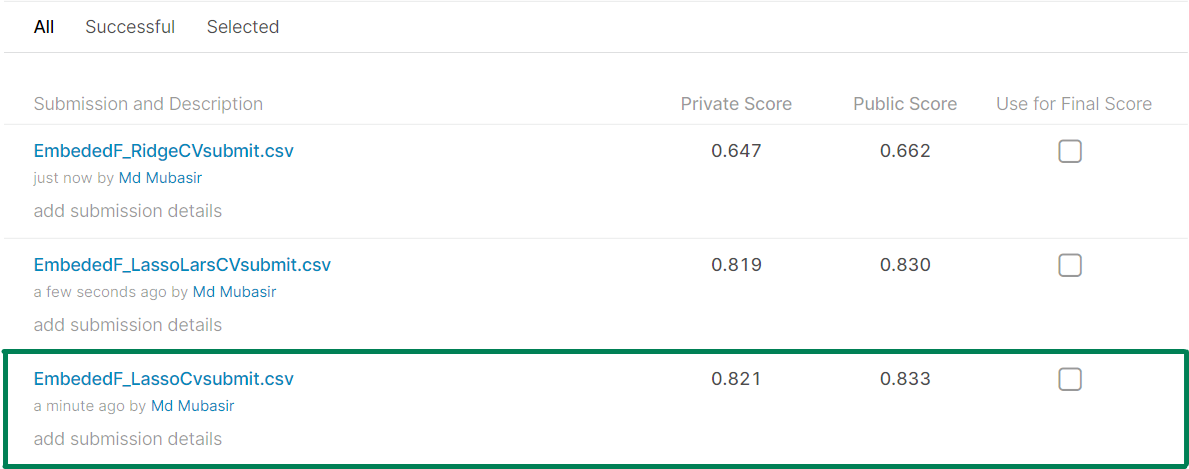

In [ ]:
Image('result/EmbeddedF/EmbeddedF_submissions.png')

# Summary
* All the models have been categorized into a type like Baseline Model, Over Sample Model and Engineered Features Model, etc. and under each type, there are 8 different classification algorithms followed by calibration got trained for the given dataset which are listed bellow
 
1. Logistic Regression (linear)
2. Linear Discriminate Analysis(linear)
3. K Neighbors Classifiers (non-linear)
4. Decision Tree (non-linear)
5. Naive Bayes (non-linear)
6. Support Vector Classifiers (non-linear)
7. Random Forest (non-linear)
8. XGBoost (non-linear)
 
 
* Lots of models have been trained let’s summarise each of this one by one
1. Baseline Model
    * In this model, the raw dataset is only standardized/scaled nothing else then trained with 8 mentioned classifiers and got the best result by **Logistic Regression** which is 0.818(private score). From the baseline model, this result is absolutely more than expected. 
2. Over Sample Model
    * In this model, we first upsampled the data points belonging to minority class with the help of the SMOTE algorithm to balance the dataset then train with all the classifiers and got good results by **XGBoost** algorithm with a score of 0.754 (private score). The score from this model is not up to the mark.
3. Over Under Sample Model
    * In this model, applied both upsample and downsample to balance the dataset then train with all the classifiers and got the best score 0.694 (private score) by **XGBoost**. This score proves that both upsampling and downsampling simultaneously might not work.
4. Engineered Features Model
    * First added 7 binning encoded features to our original dataset then train with all the classifiers and got maximum score 0.762(private score) by **Logistic Regression** algorithm ). It is clearly perceived that our engineered features even degrade the performance and it did not work for this problem.
5. Mutual Information Model
    * In this model, mutual information which is a filter-based feature selection method has been applied to select only the best features and then train with all the classifiers. **SVC** algorithm gave a good score of 0.666 (private score). From this score, it can easily be concluded that this is not the best feature selection method for this problem.
6. Sequential Forward Selection(SFS) Model
    * In this model, SFS, a wrapper based method for feature selection has been applied and selected top 20 features and then train all the classifiers with these features only. got the best score of 0.710(private score) by **Random Forest**. This core also proves that it is not the best feature selection method for this problem
7. Sequential Forward Floating Selection(SFFS) Model
    * In this model, SFFS, a wrapper based feature selection method has been applied and selected top 17 features and train all classifiers with these features and got the best score 0.712(private score) by **Naive Bayes**. This method also did not increase the score.
8. Recursive Feature Elimination(RFE) Model
    * In this model, RFE, a wrapper based feature selection method has been applied, used best baseline classifiers as an estimator to the RFE method, and got a really good result 0.838(private score). This the result we are waiting for. This method of feature selection performed well for this problem.
9.  Embedded Model
    * In this model, the embedded method of feature selection has been applied and used 3 different embedded algorithms that are LassoCv, LassoLarsCV, and RidgeCV and got very score 0.821 result by **LassoCV** algorithm. This method of feature selection becomes one of the best methods for our problem.


# Ranking All the Models based on their private score



In [ ]:
x = PrettyTable()
x.field_names = ['Rank','Model Name', 'Classifiers Used', 'Kaggle public score', 'Kaggle private score']
x.add_row([1,'RFE', 'Logistic Regression','0.849', '0.838'])
x.add_row([2,'Embedded', 'LassoCV', '0.833', '0.821'])
x.add_row([3,'Embedded', 'LassoLarsCv', '0.830','0.819'])
x.add_row([4,'Baseline', 'Logistic Regression', '0.833', '0.818'])
x.add_row([5,'Engineered Features', 'Logistic Regression','0.797','0.762'])
x.add_row([6,'Over Sample','XGBoost','0.778','0.754'])
x.add_row([7,'SFFS','Naive Bayes','0.715','0.712'])
x.add_row([8,'SFS','Random Forest','0.720','0.710'])
x.add_row([9,'Over Under Sample','XGBoost','0.705','0.694'])
x.add_row([10,'Mutual Information','Suport Vector Classifiers','0.682','0.666'])
print(x)

+------+---------------------+---------------------------+---------------------+----------------------+
| Rank |      Model Name     |      Classifiers Used     | Kaggle public score | Kaggle private score |
+------+---------------------+---------------------------+---------------------+----------------------+
|  1   |         RFE         |    Logistic Regression    |        0.849        |        0.838         |
|  2   |       Embedded      |          LassoCV          |        0.833        |        0.821         |
|  3   |       Embedded      |        LassoLarsCv        |        0.830        |        0.819         |
|  4   |       Baseline      |    Logistic Regression    |        0.833        |        0.818         |
|  5   | Engineered Features |    Logistic Regression    |        0.797        |        0.762         |
|  6   |     Over Sample     |          XGBoost          |        0.778        |        0.754         |
|  7   |         SFFS        |        Naive Bayes        |      